# **Part 0: Necessary Imports**
Here, we will import the required Python libraries and load our dataset.

In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Getting the CSV file from Google Drive

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/electricity_prices.csv', 'r') as f:
  df = pd.read_csv(f)

Mounted at /content/drive


# **Part 1: Exploratory Data Analysis (EDA)**
Here, we will explore the data, find any anomalies, and visualize them through plots and graphs.

## Section I: States vs. Regions
Our dataset contains data from 50 different states. However, it also contains data for the different regions.

In [ ]:
unique_states = df['stateDescription'].unique()
print(unique_states)
print()

num_unique_states = df['stateDescription'].nunique()
print("Number of unique states/regions:", num_unique_states)

['Wyoming' 'New England' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Alabama' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts'
 'Michigan' 'Minnesota' 'Mississippi' 'Middle Atlantic'
 'Pacific Contiguous' 'Pacific Noncontiguous' 'U.S. Total' 'Missouri'
 'Montana' 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico'
 'New York' 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon'
 'Rhode Island' 'Alaska' 'Arizona' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida'
 'East North Central' 'West North Central' 'South Atlantic'
 'East South Central' 'West South Central' 'Mountain' 'Pennsylvania']

Number of unique states/regions: 62


In [ ]:
# Created two new dataframes: geographical areas and states

geographical_areas = ['East North Central', 'West North Central', 'South Atlantic',
                      'East South Central', 'West South Central', 'Mountain', 'U.S. Total',
                      'Middle Atlantic', 'Pacific Contiguous', 'Pacific Noncontiguous',
                      'District of Columbia', 'New England']

df_regions = df[df['stateDescription'].isin(geographical_areas)]


unique_areas = df_regions['stateDescription'].unique()
print(unique_areas)
print()

num_unique_areas = df_regions['stateDescription'].nunique()
print("Number of unique areas:", num_unique_areas)
print()

df_states  = df.drop(df_regions.index)
print(df_states.shape)
print(df_regions.shape)

['New England' 'Middle Atlantic' 'Pacific Contiguous'
 'Pacific Noncontiguous' 'U.S. Total' 'District of Columbia'
 'East North Central' 'West North Central' 'South Atlantic'
 'East South Central' 'West South Central' 'Mountain']

Number of unique areas: 12

(69250, 8)
(16620, 8)


## Section II: Missing Values
Our dataset may contain missing values. Here, we will find them and see how we could fix them.

The first step is to see if there are any null values, and if so, where they're located.

In [ ]:
df_states.isnull().sum()

year                    0
month                   0
stateDescription        0
sectorName              0
customers           21000
price                   0
revenue                 0
sales                   0
dtype: int64

The *customers* column contains 21,000 null values, which makes up a third of the whole data. This amount is too high to ignore to remove, so we must replace it with something else.

To replace it, we must use a value that accuratly represents the data. This could be a mean, median, mode, etc. The one that works best would be the value that, when used to fill the dataset, would maintain the correlation between the *customers* column and the label, *price*.

The correlation between *customers* and other columns like *price*, *revenue*, and *sales* is shown below. We make sure to remove the examples will null values beforehand.

In [ ]:
correlated_columns = ['customers', 'price', 'revenue', 'sales']

df_with_customers = df_states.loc[df_states['customers'].notnull()][correlated_columns]
df_with_customers.corr()

customers     price   revenue     sales
customers   1.000000  0.241719  0.866534  0.805044
price       0.241719  1.000000  0.219229  0.097654
revenue     0.866534  0.219229  1.000000  0.941299
sales       0.805044  0.097654  0.941299  1.000000

Let's try replacing the null values with different statistics and see how the generated correlations compare to those above.

First, we can try the **mode**.

In [ ]:
customers_mode = df_with_customers['customers'].mode()[0]
df_with_mode = df_states.fillna(customers_mode, inplace = False)

df_with_mode[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.266811  0.767533  0.666223
price       0.266811  1.000000  0.232876  0.101523
revenue     0.767533  0.232876  1.000000  0.937108
sales       0.666223  0.101523  0.937108  1.000000

Next, we can try the **median**.

In [ ]:
customers_median = df_with_customers['customers'].median()
df_with_median = df_states.fillna(customers_median, inplace = False)

df_with_median[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.256792  0.774643  0.676025
price       0.256792  1.000000  0.232876  0.101523
revenue     0.774643  0.232876  1.000000  0.937108
sales       0.676025  0.101523  0.937108  1.000000

Finally, we can try the **mean**.

In [ ]:
customers_mean = df_with_customers['customers'].mean()
df_with_mean = df_states.fillna(customers_mean, inplace = False)

df_with_mean[correlated_columns].corr()

customers     price   revenue     sales
customers   1.000000  0.212642  0.775483  0.689676
price       0.212642  1.000000  0.232876  0.101523
revenue     0.775483  0.232876  1.000000  0.937108
sales       0.689676  0.101523  0.937108  1.000000

Of all the 3 cases, the data where the mean was used as the replacement has the most similar values to the original correlation. So, we can use the mean as the replacement.

In [ ]:
df_states = df_states.fillna(customers_mean)
df_states

year  month stateDescription      sectorName     customers  price  \
0      2001      1          Wyoming     all sectors  1.203000e+06   4.31   
1      2001      1          Wyoming      commercial  1.203000e+06   5.13   
2      2001      1          Wyoming      industrial  1.203000e+06   3.26   
3      2001      1          Wyoming           other  1.203000e+06   4.75   
4      2001      1          Wyoming     residential  1.203000e+06   6.01   
...     ...    ...              ...             ...           ...    ...   
85865  2024      1         Arkansas     all sectors  1.717720e+06   9.63   
85866  2024      1         Arkansas      commercial  2.086690e+05  10.26   
85867  2024      1         Arkansas      industrial  3.495100e+04   7.08   
85868  2024      1         Arkansas     residential  1.474098e+06  11.24   
85869  2024      1         Arkansas  transportation  2.000000e+00  12.70   

         revenue       sales  
0       48.12840  1116.17208  
1       12.67978   247.08691  
2       19.60858   602.30484  
3        0.76868    16.17442  
4       15.07136   250.60591  
...          ...         ...  
85865  442.98773  4598.63147  
85866   97.79467   953.02154  
85867  109.92656  1553.02838  
85868  235.26399  2092.56172  
85869    0.00252     0.01984  

[69250 rows x 8 columns]

## Section III: Visualizing The Data (clean this)
Here, we will use graphs/plots and Auto EDA tools to visualize our data and find any notable trends.

###**SWEETVIZ**

In [ ]:
!pip install sweetviz
import sweetviz as sv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 82.4 MB/s eta 0:00:00


Next we can generate reports for both the general dataset and the dataset excluding the null values.

                                             |          | [  0%]   00:00 -> (? left)


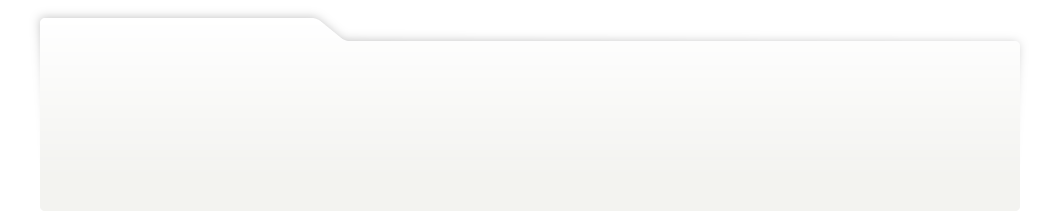
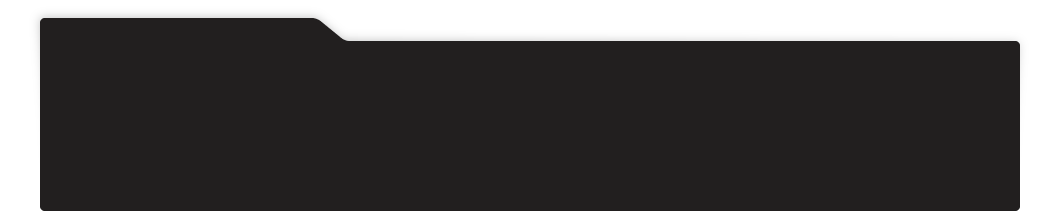
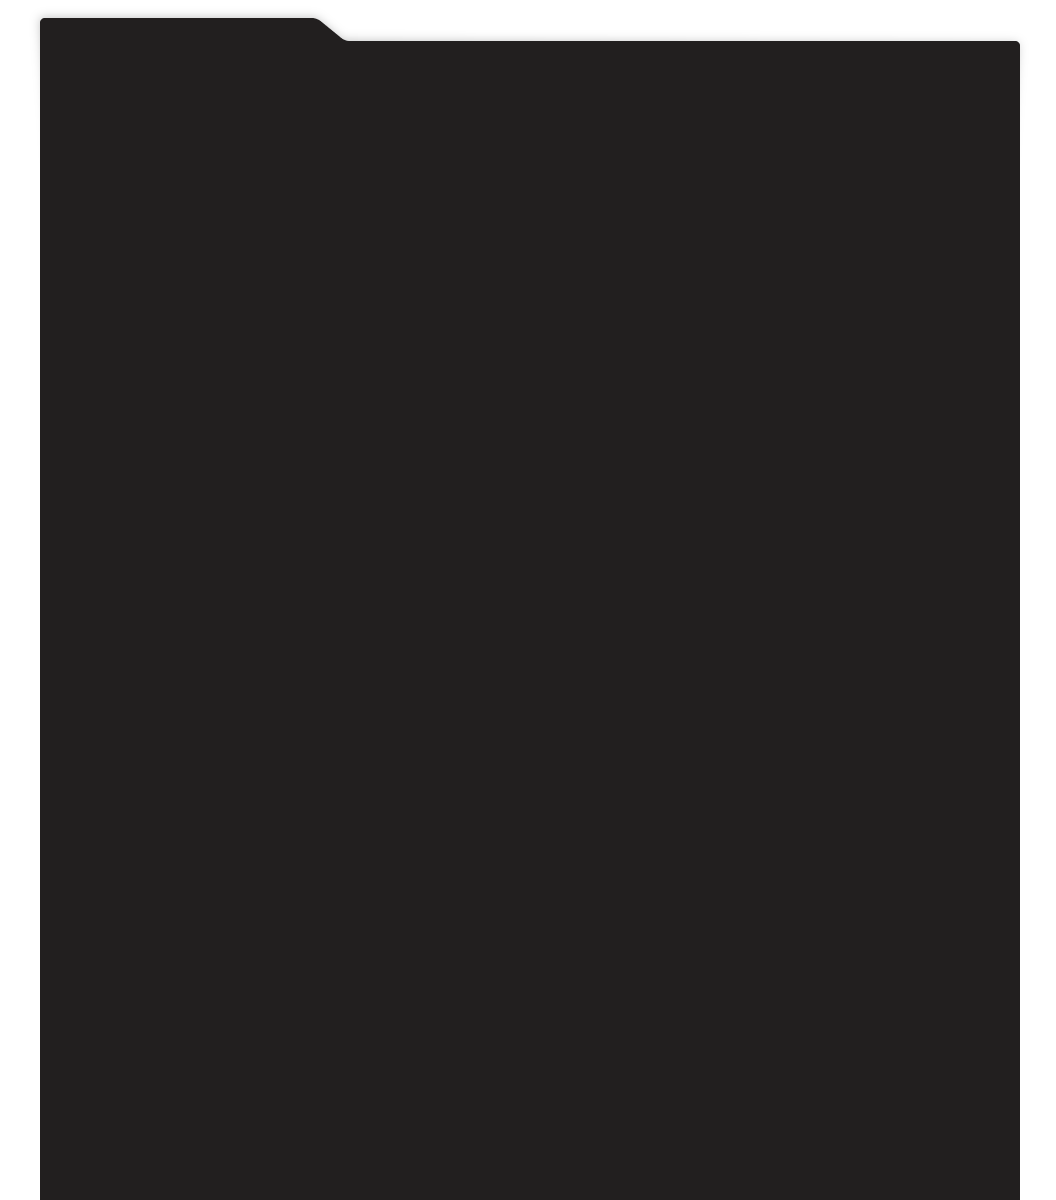
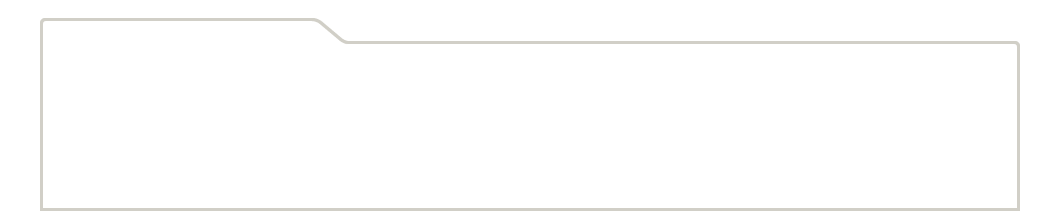
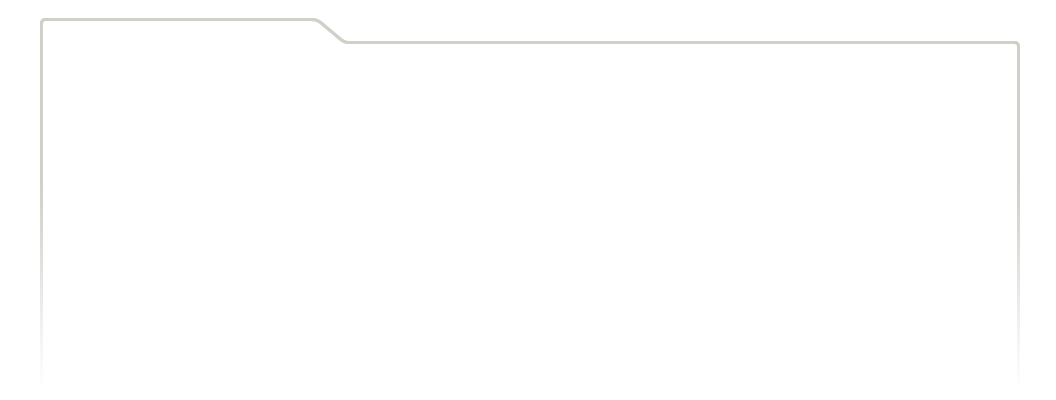
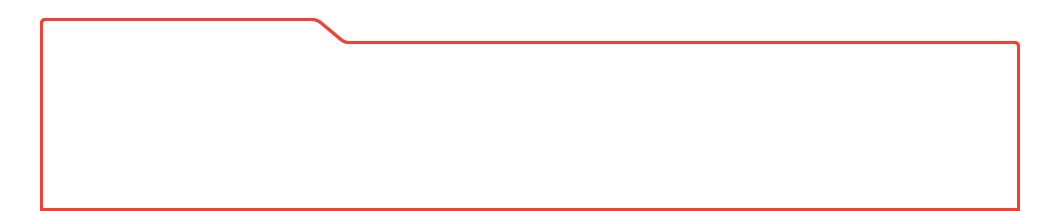
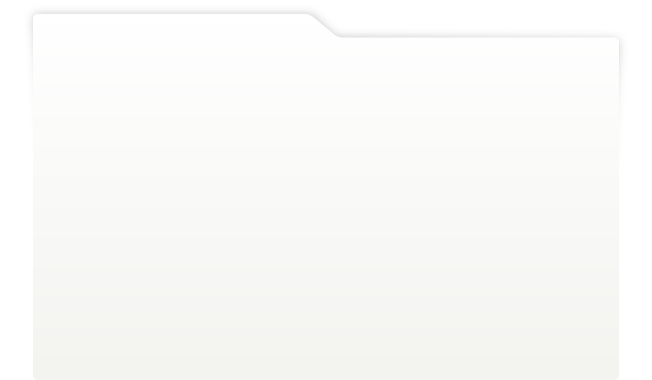
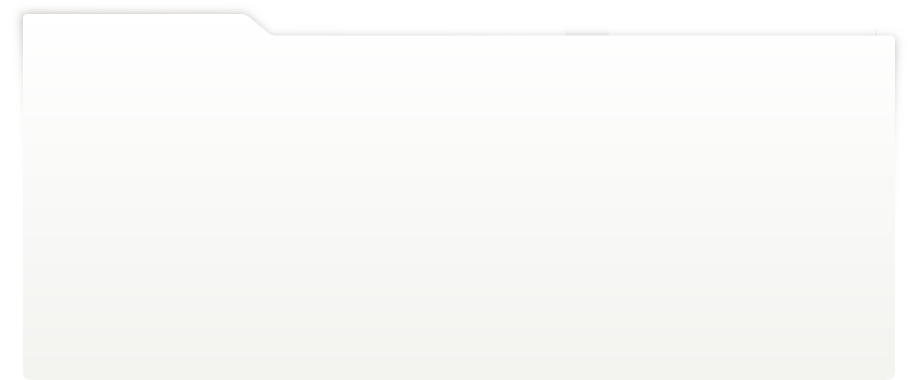
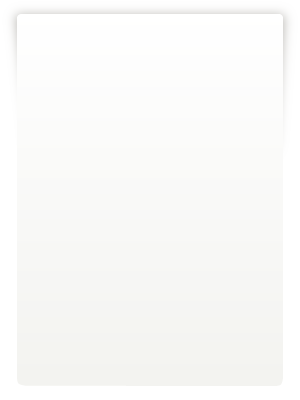
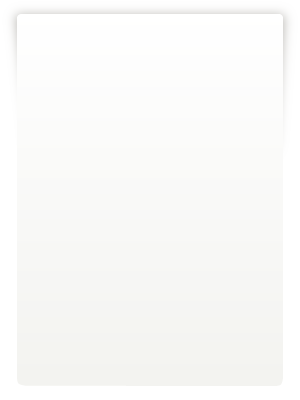
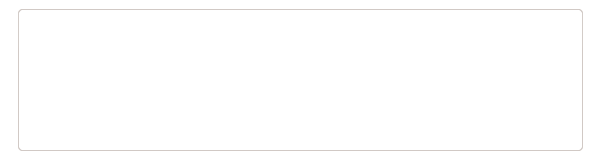
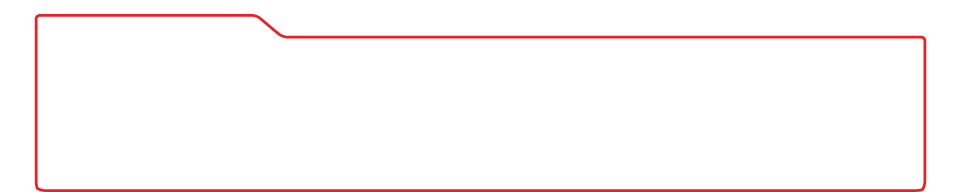
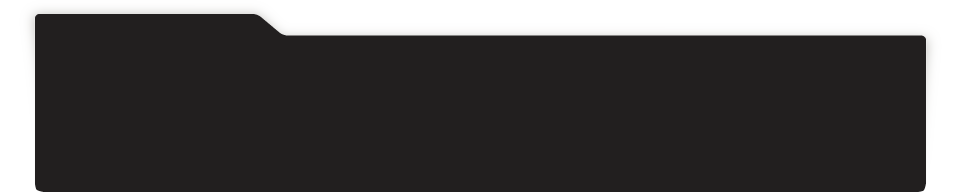
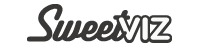
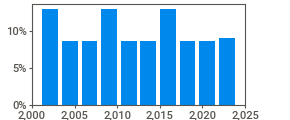
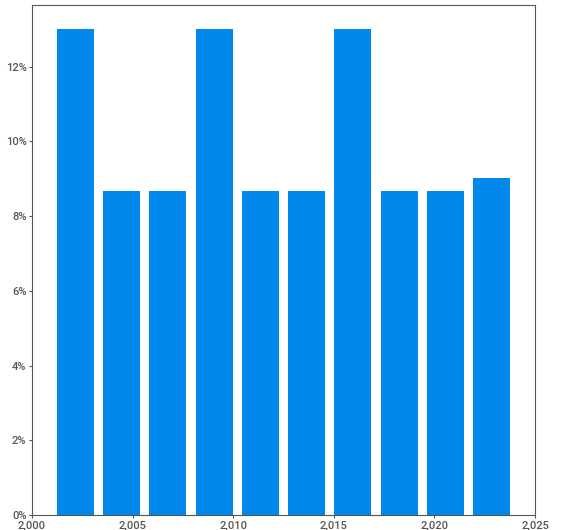
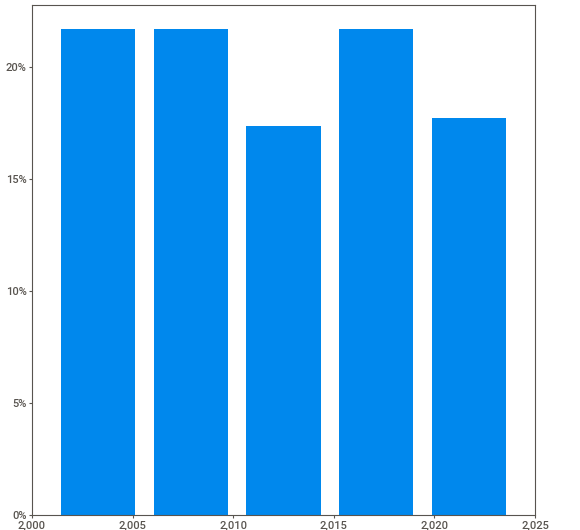
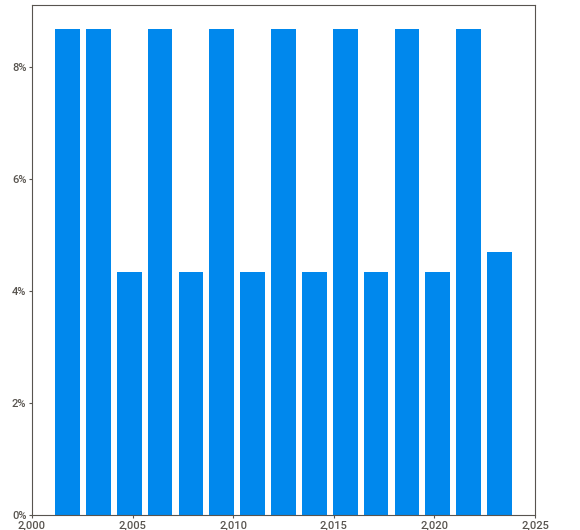
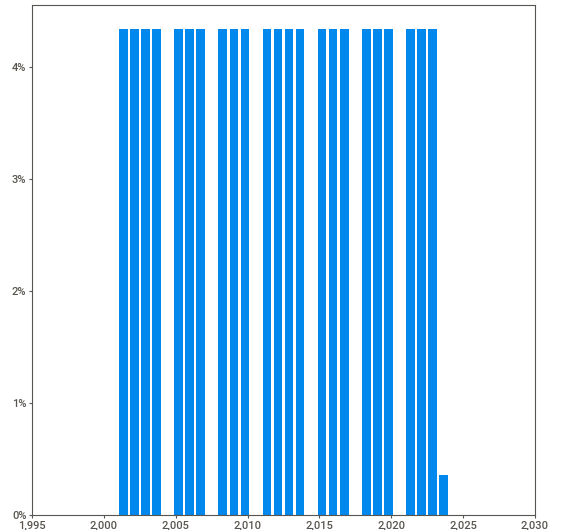
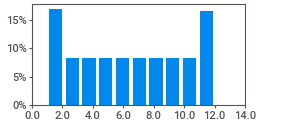
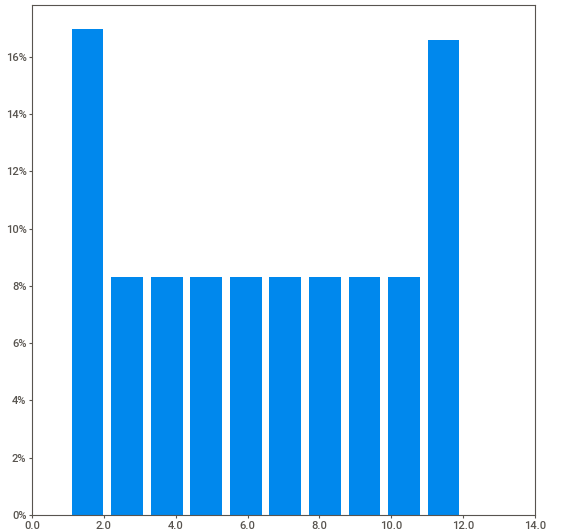
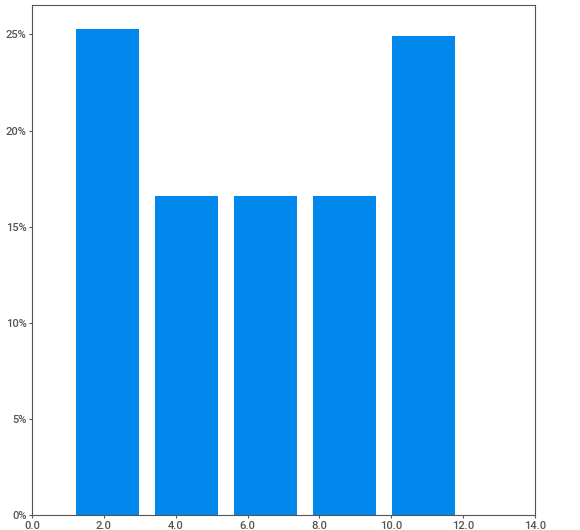
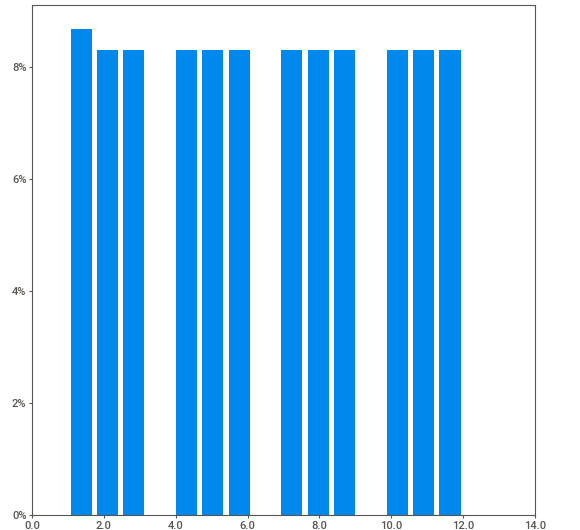
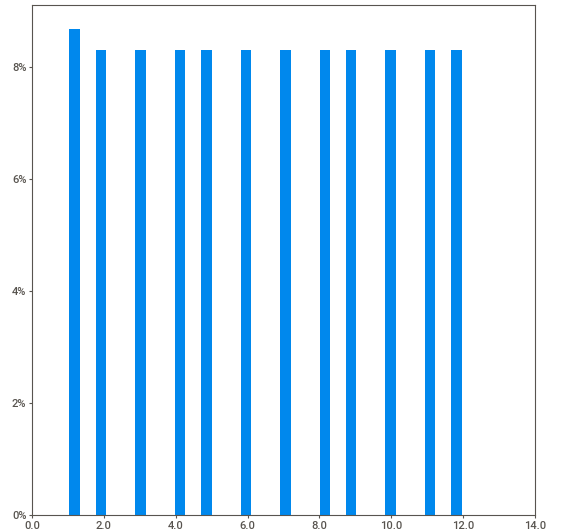
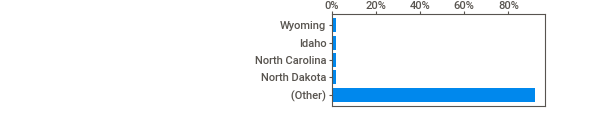
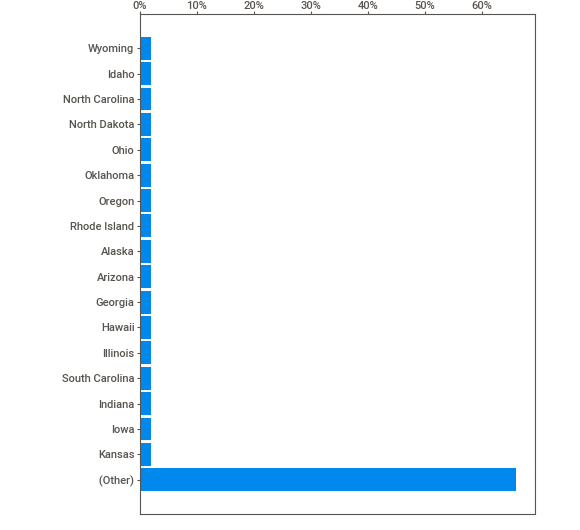
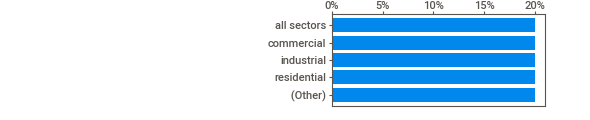
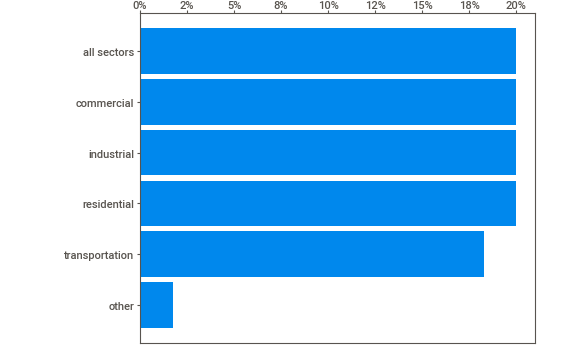
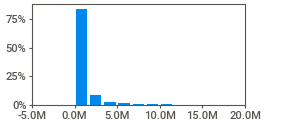
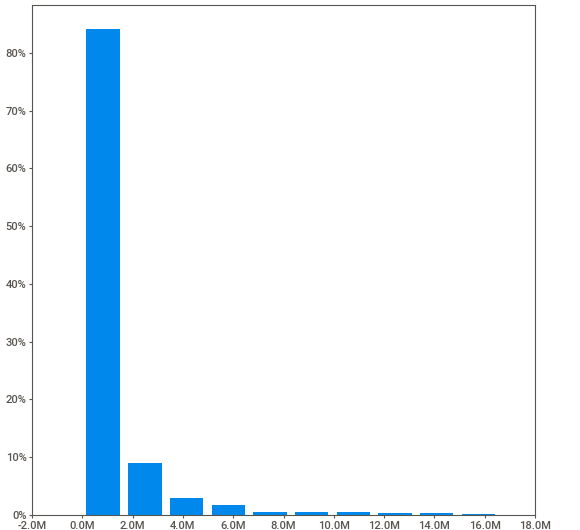
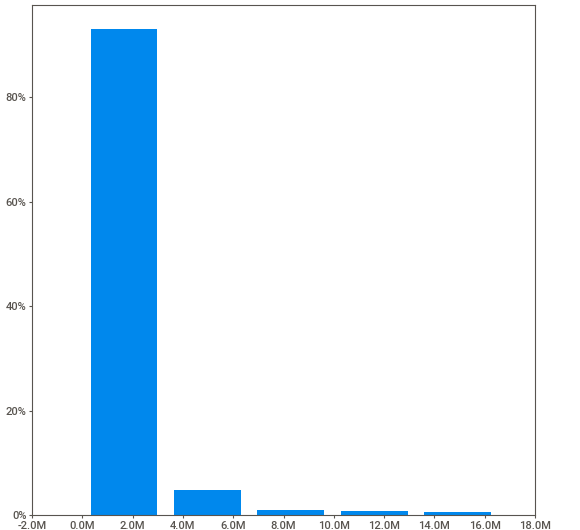
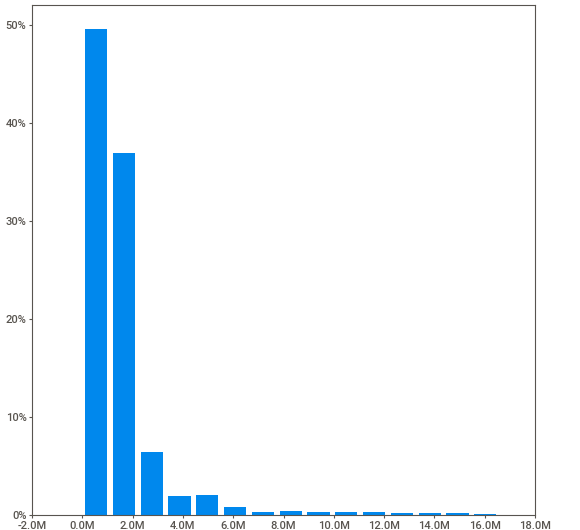
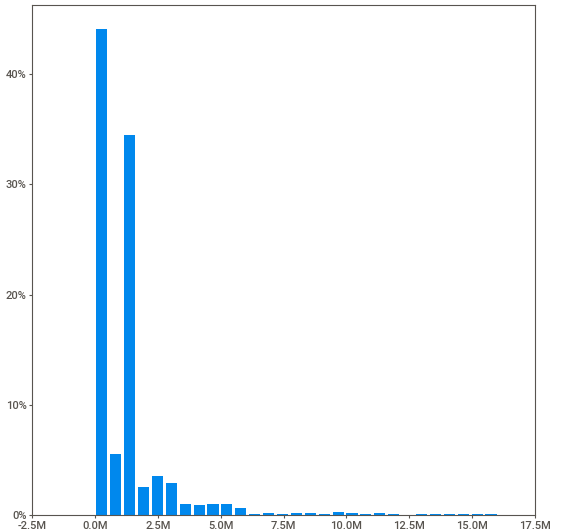
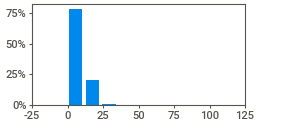
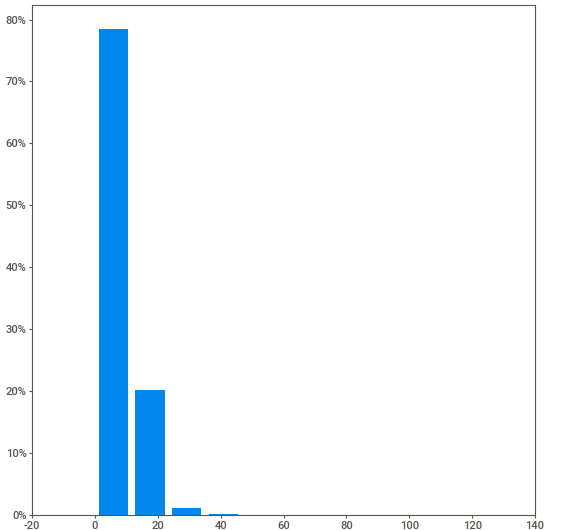
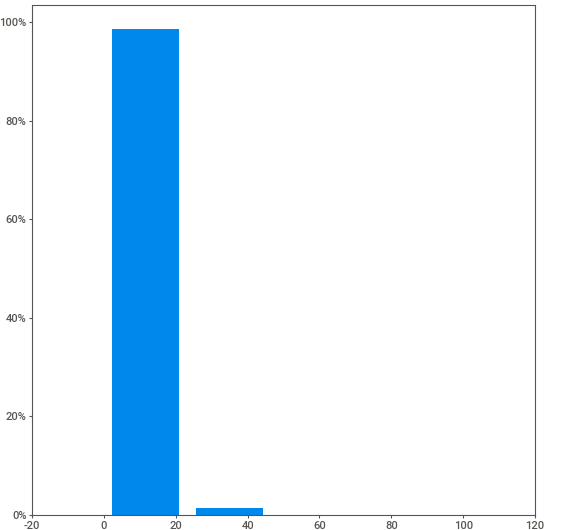
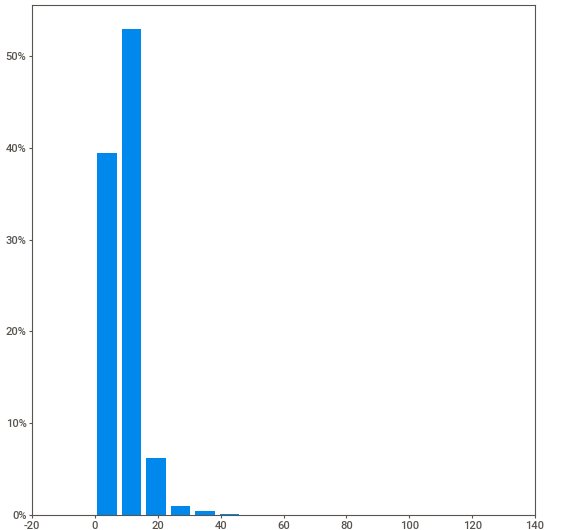
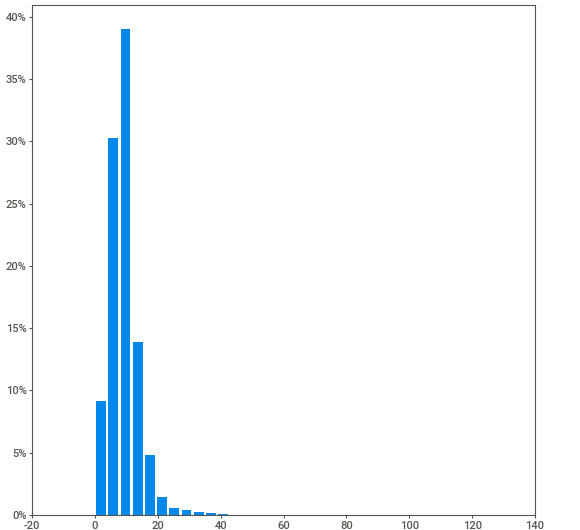
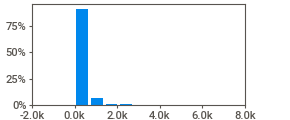
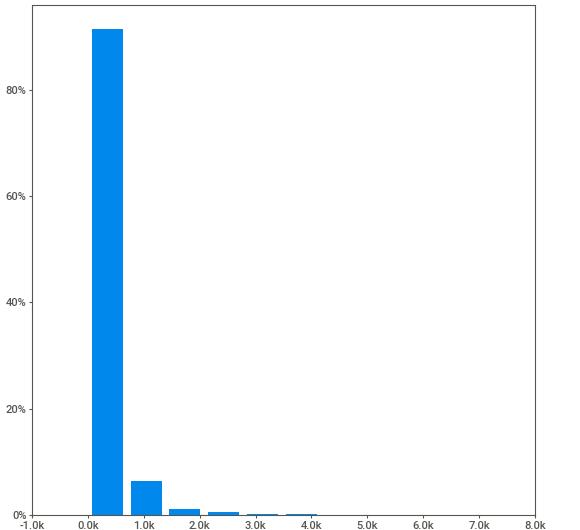
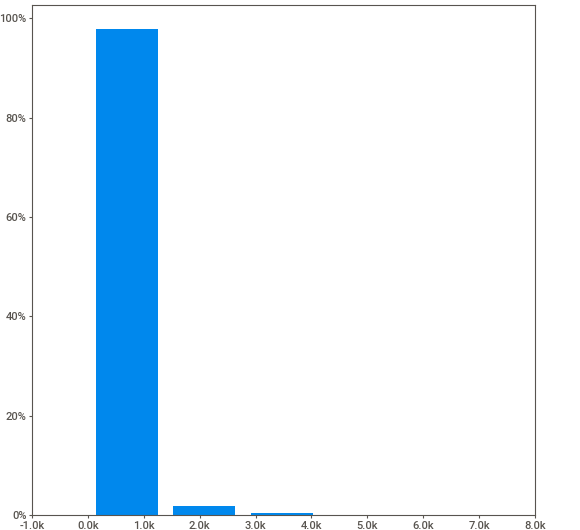
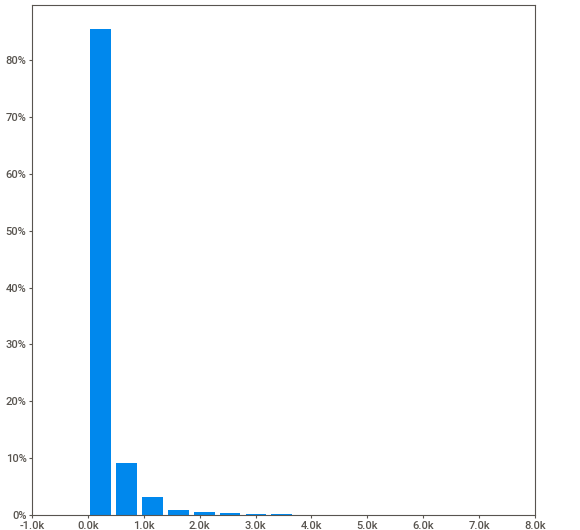
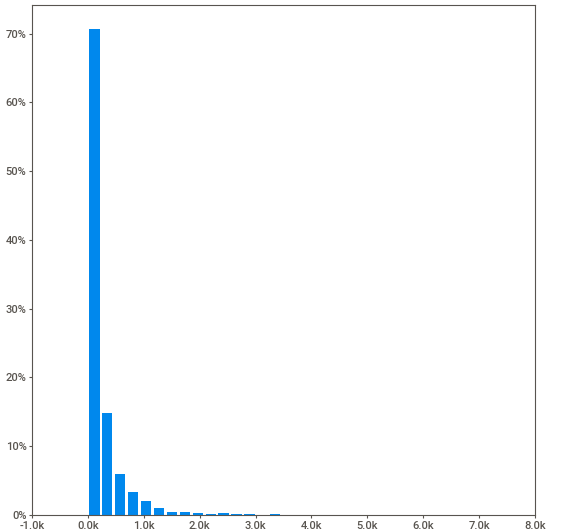
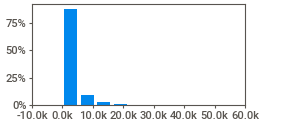
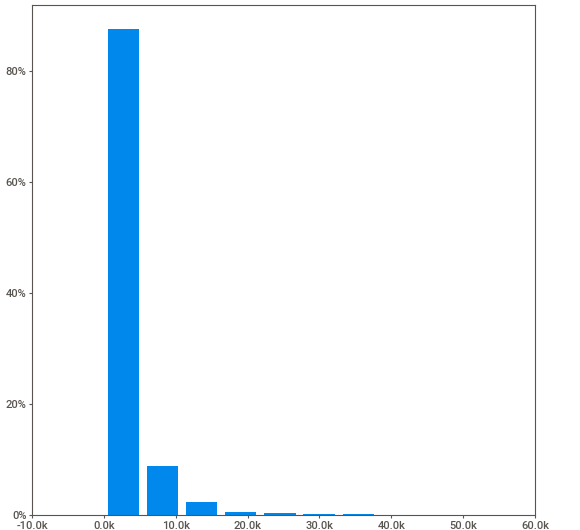
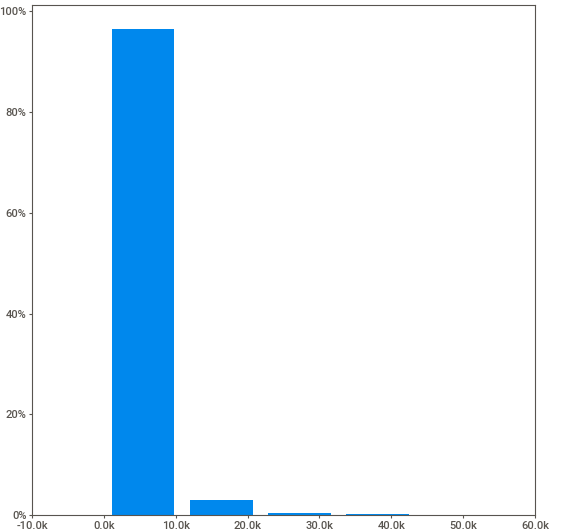
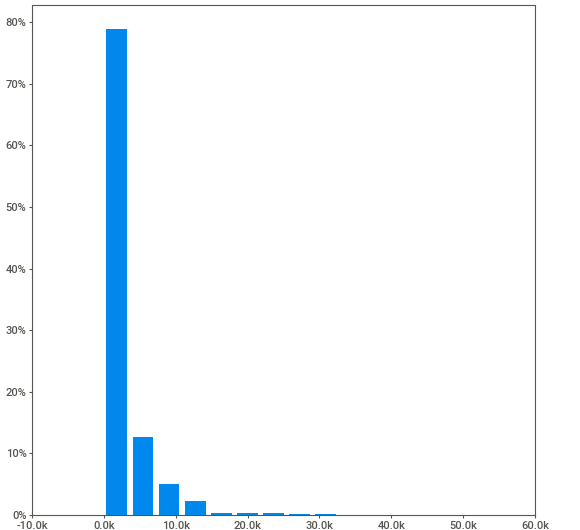
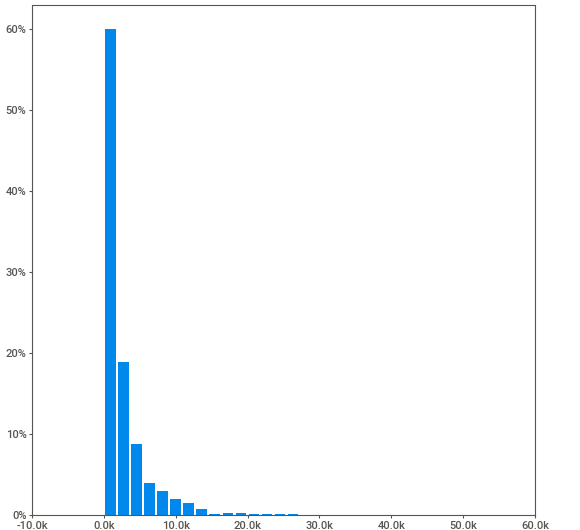
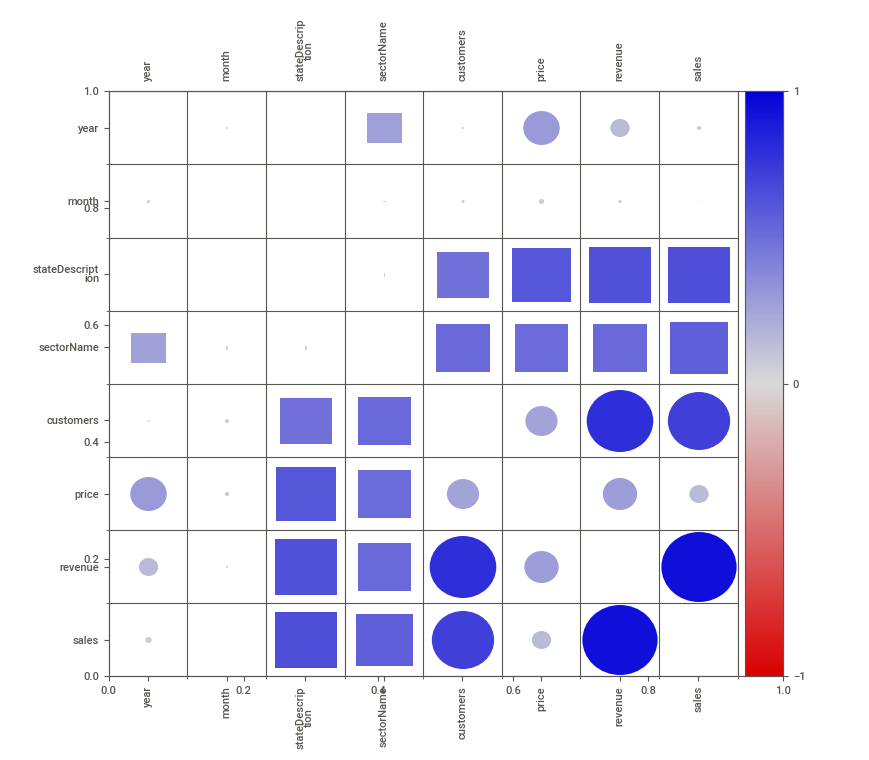
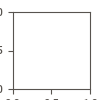

In [ ]:
#for general dataset
general_df = sv.analyze(df_states)
general_df.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


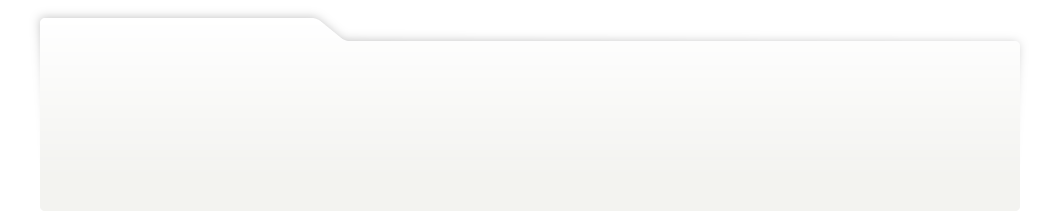
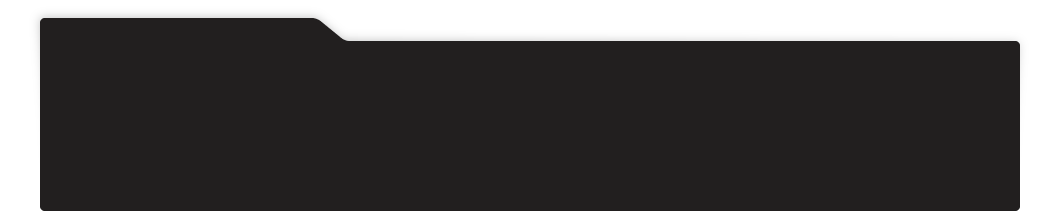
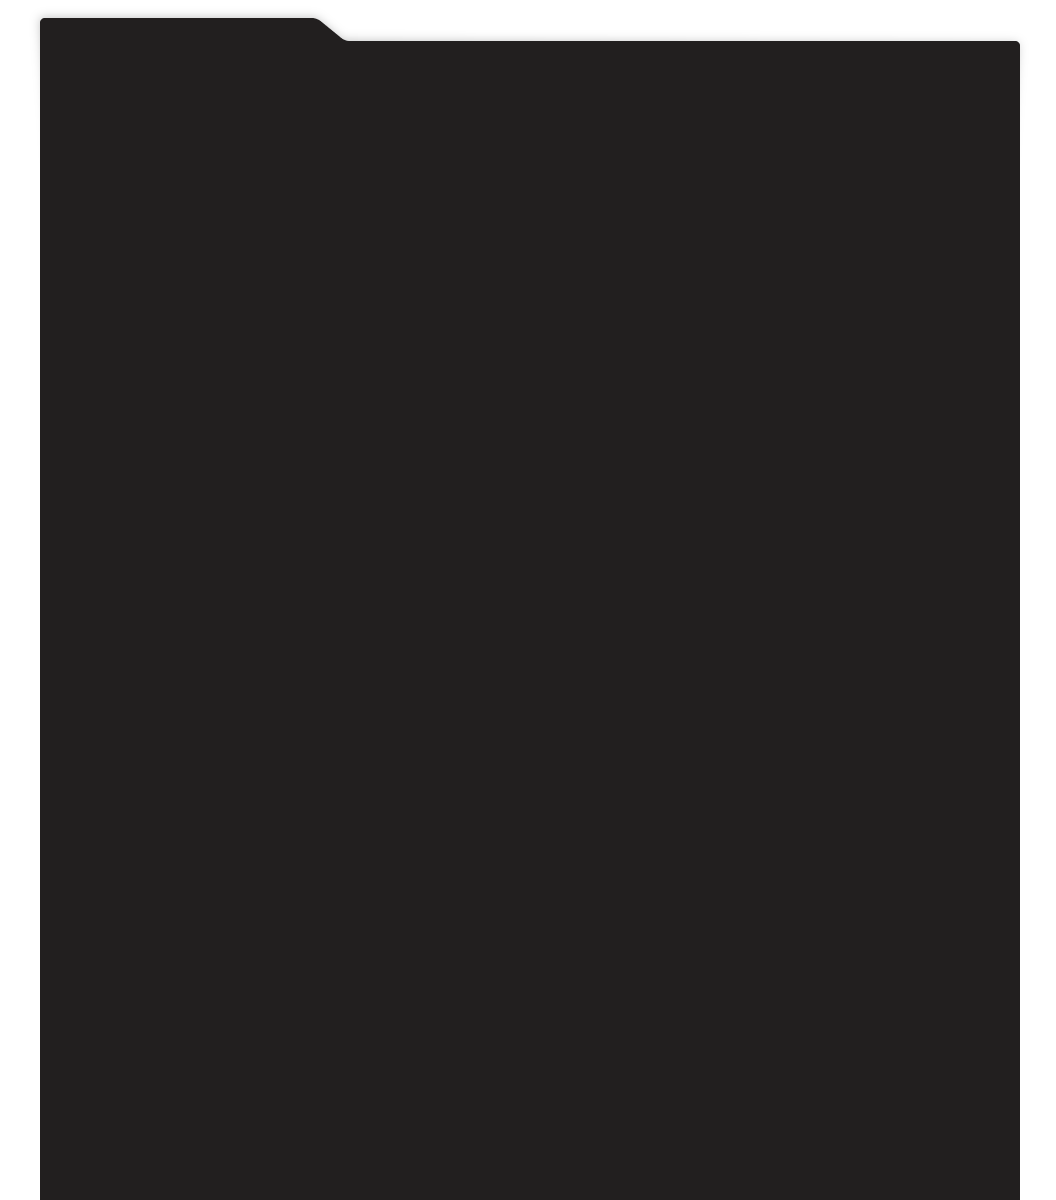
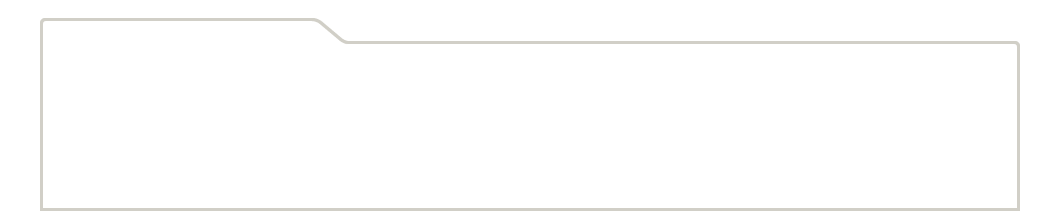
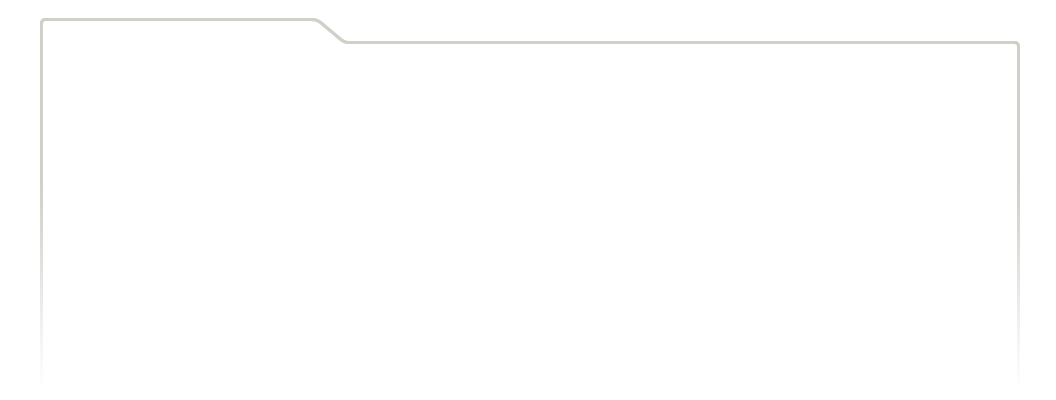
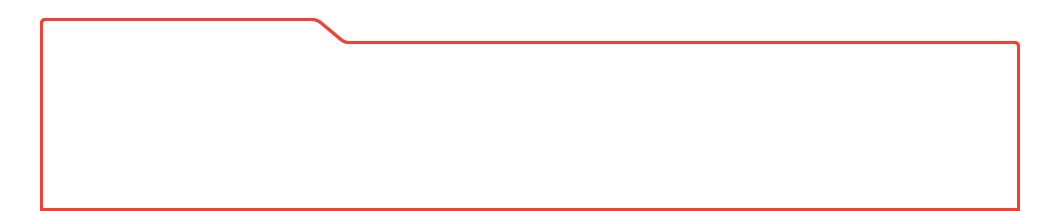
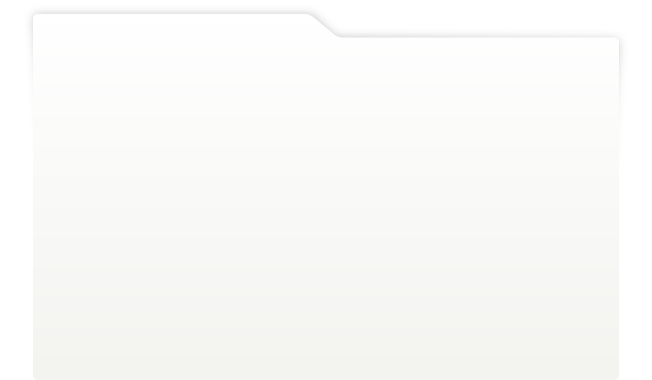
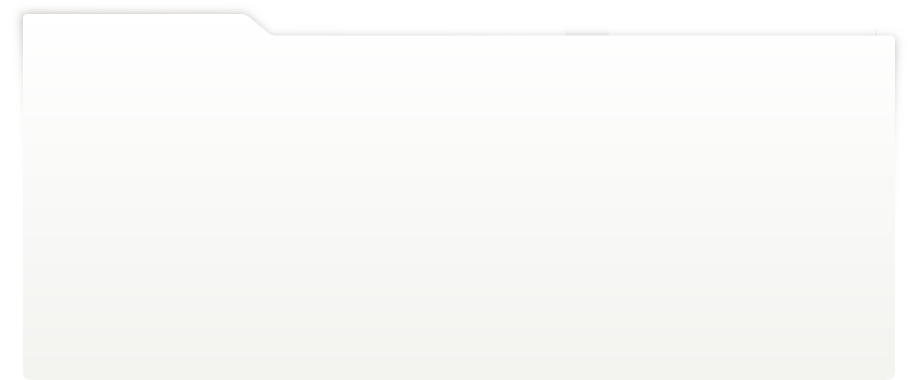
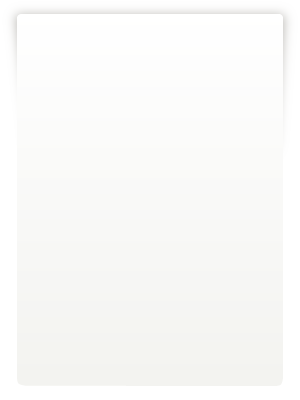
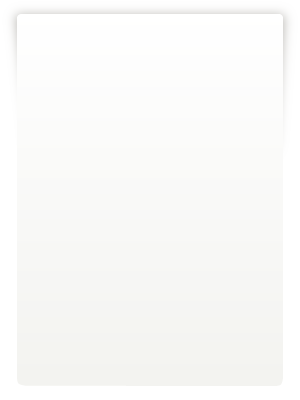
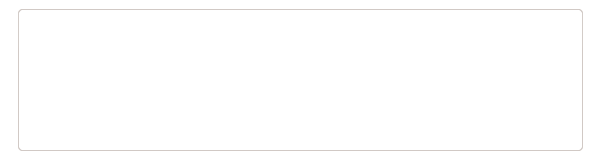
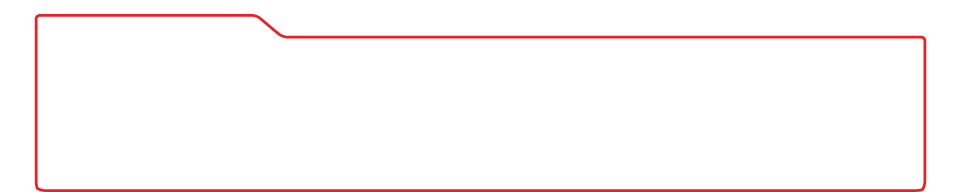
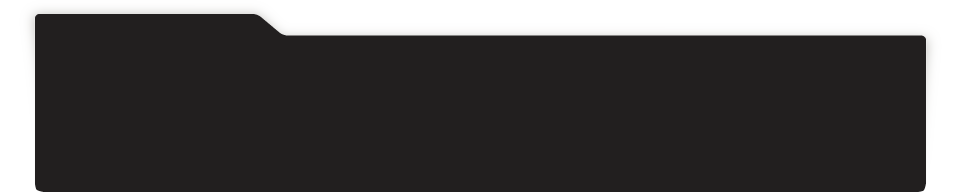
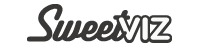
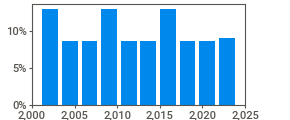
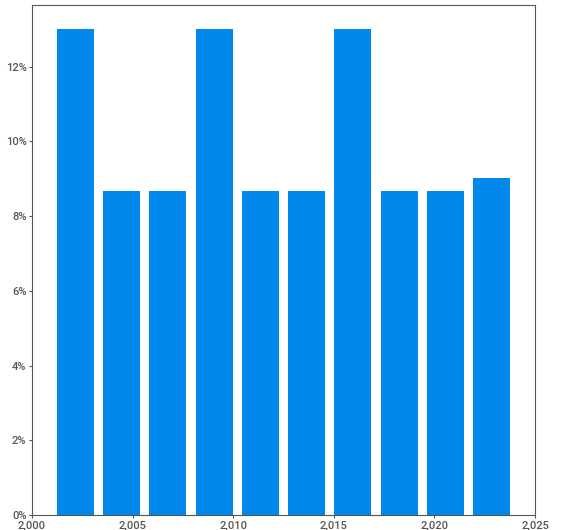
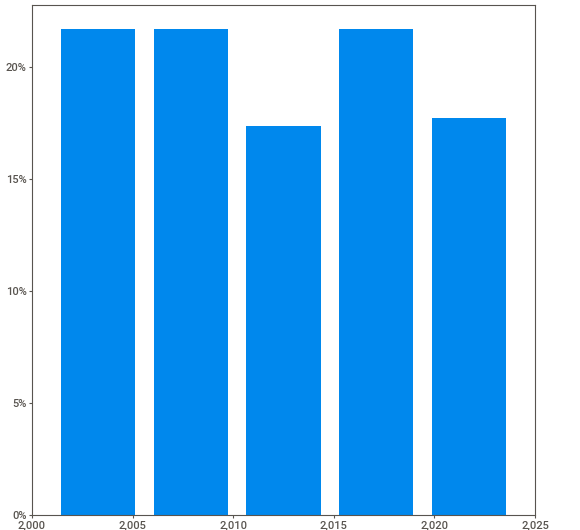
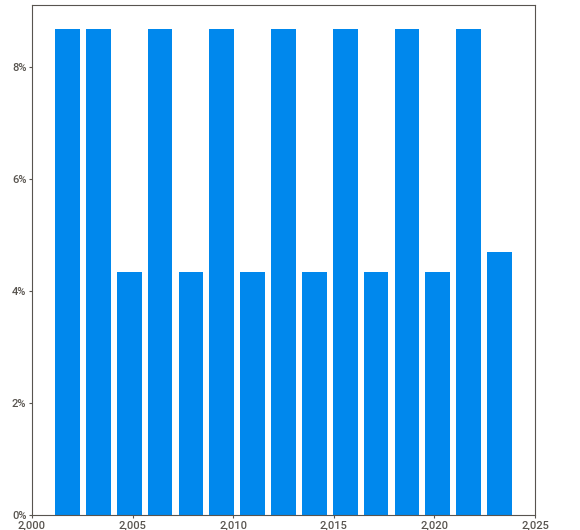
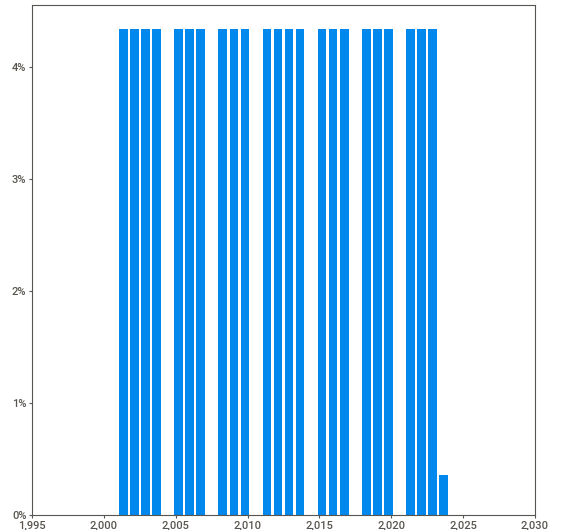
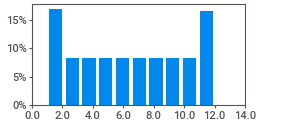
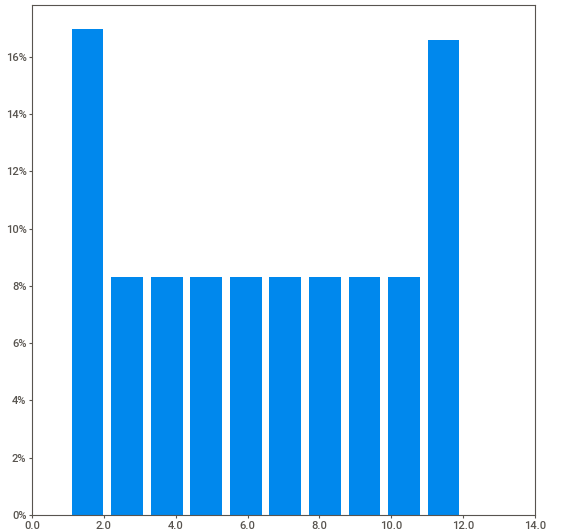
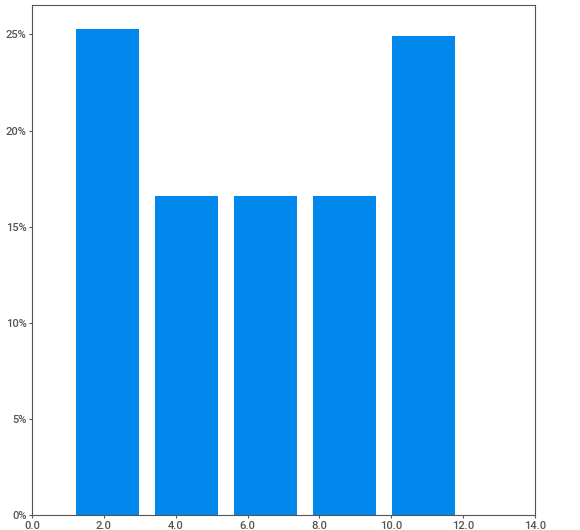
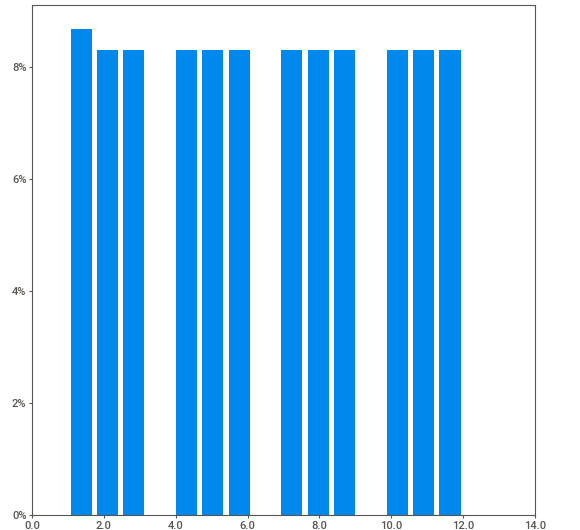
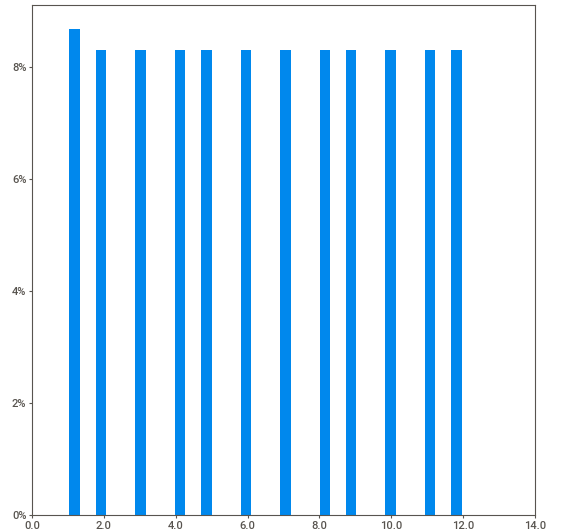
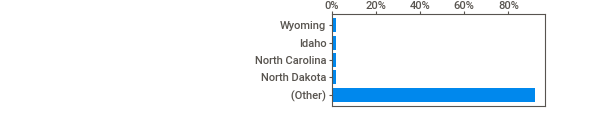
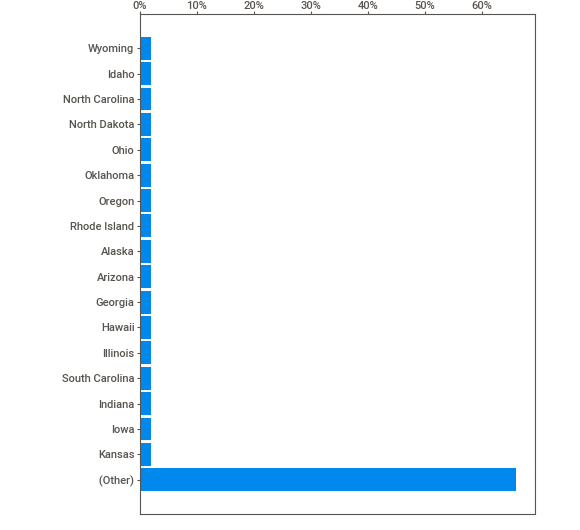
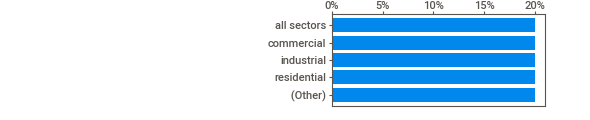
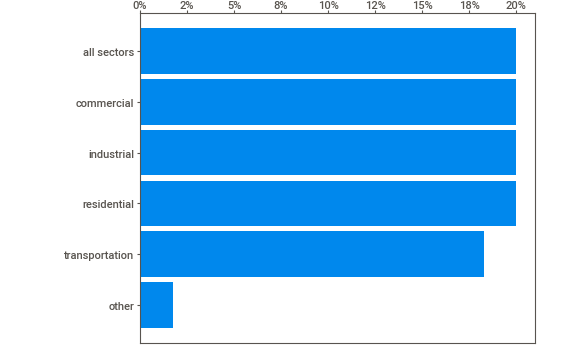
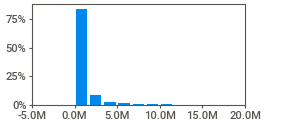
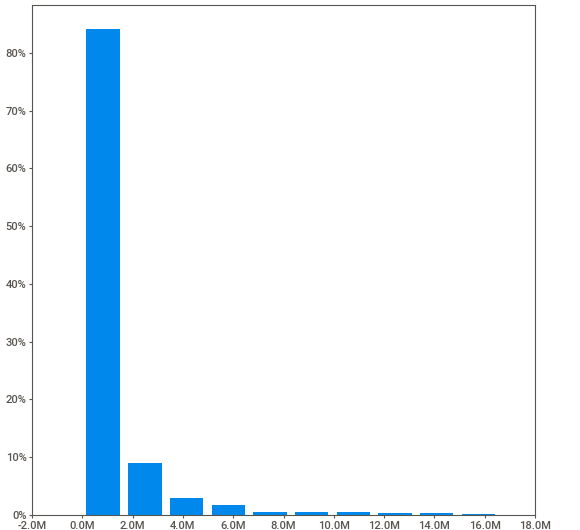
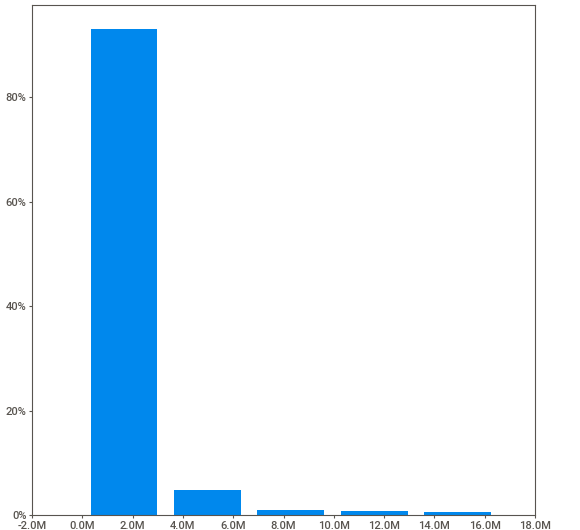
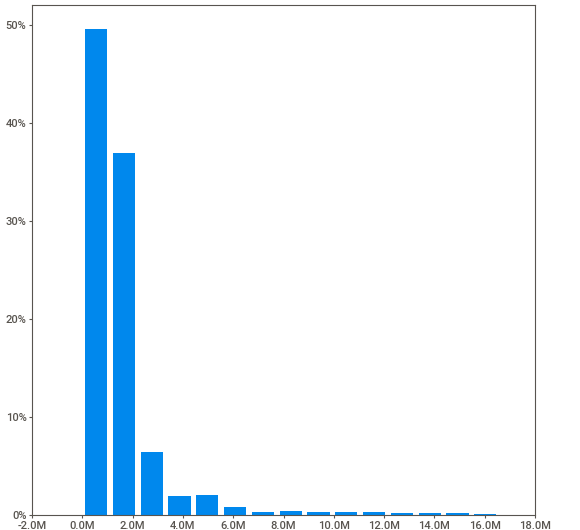
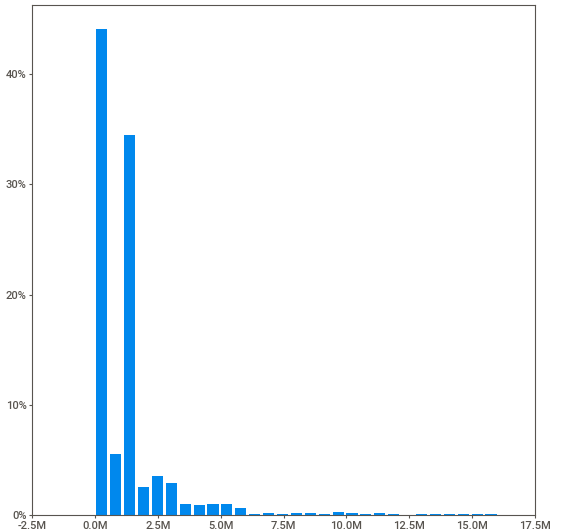
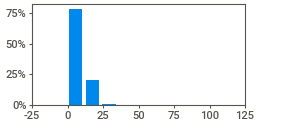
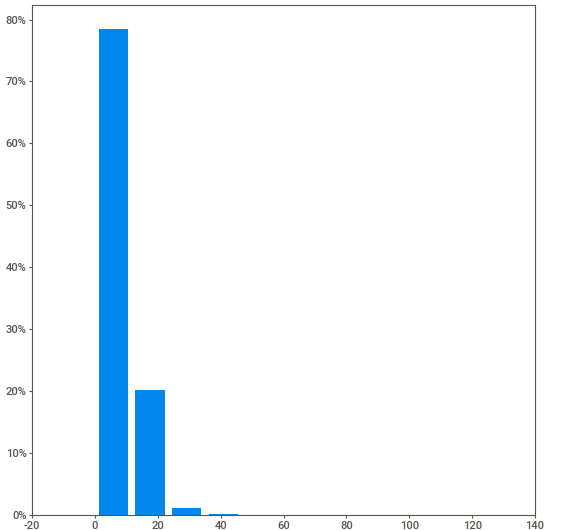
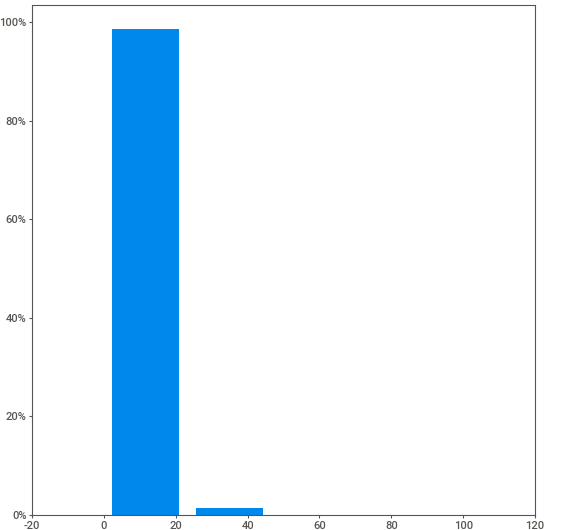
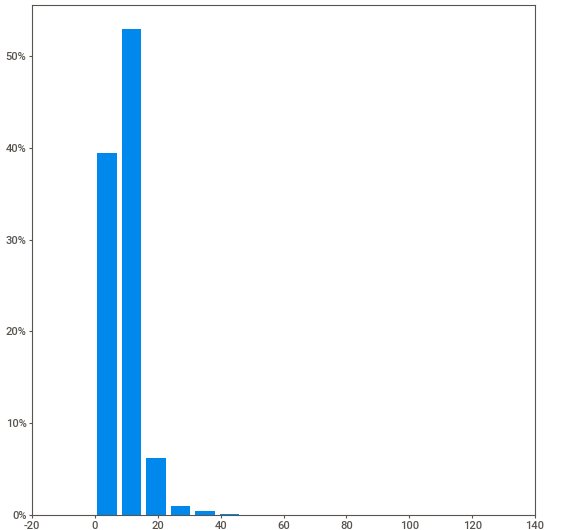
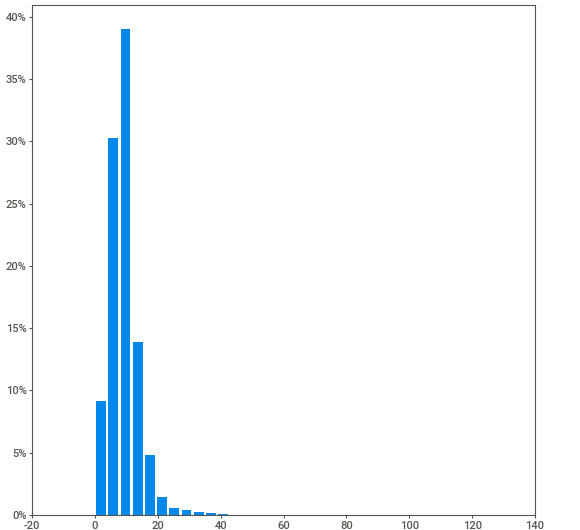
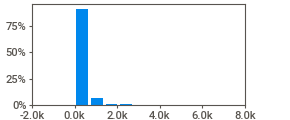
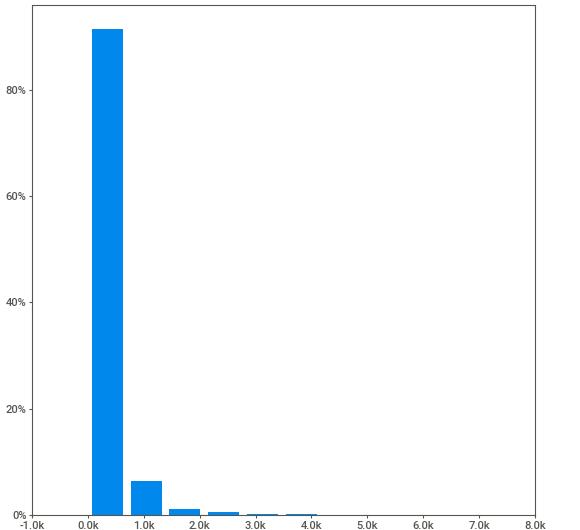
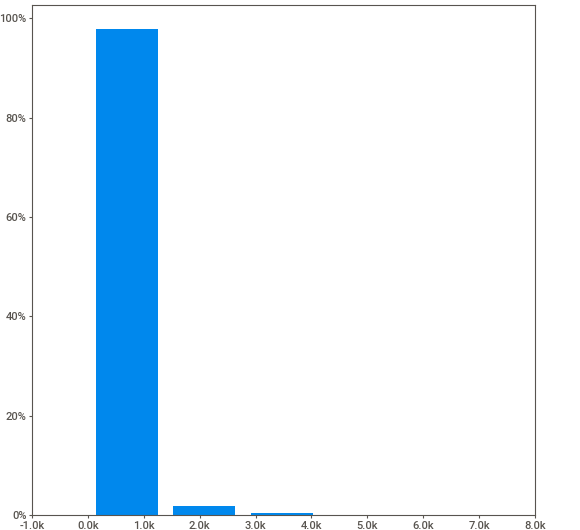
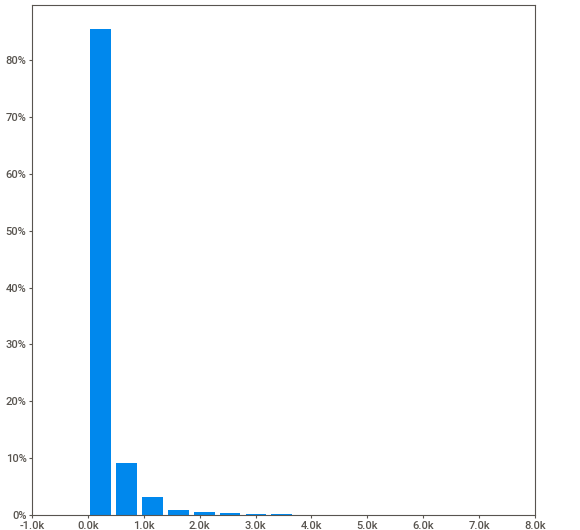
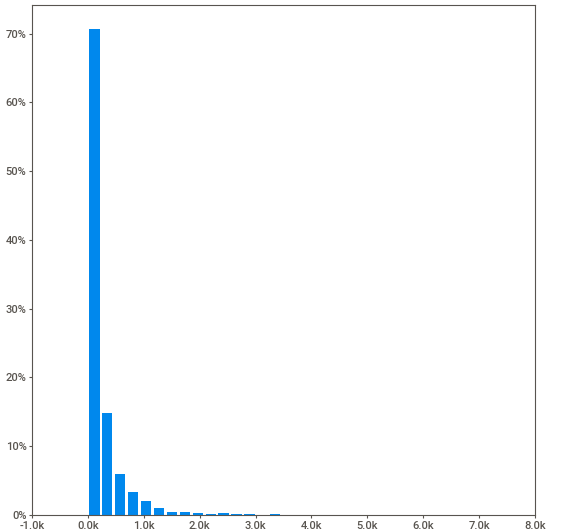
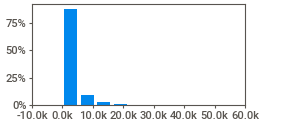
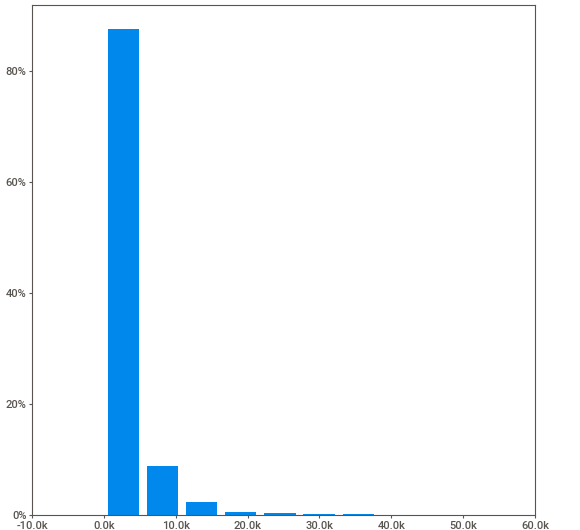
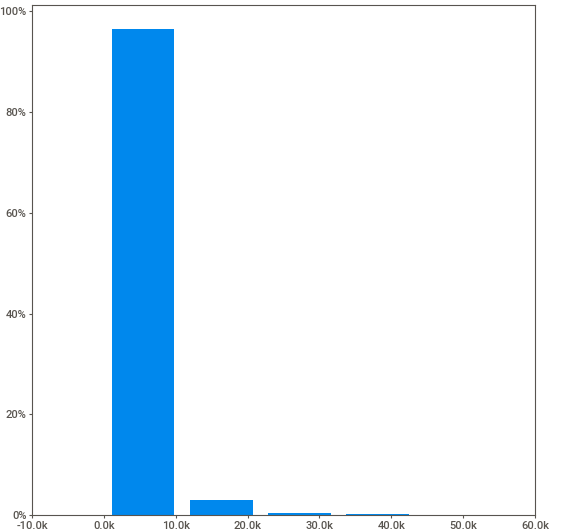
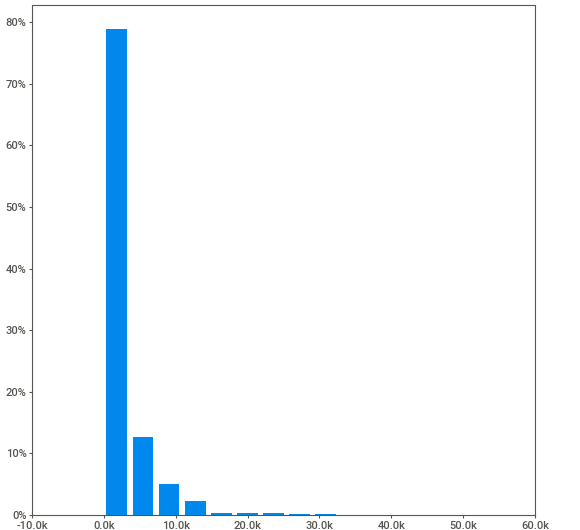
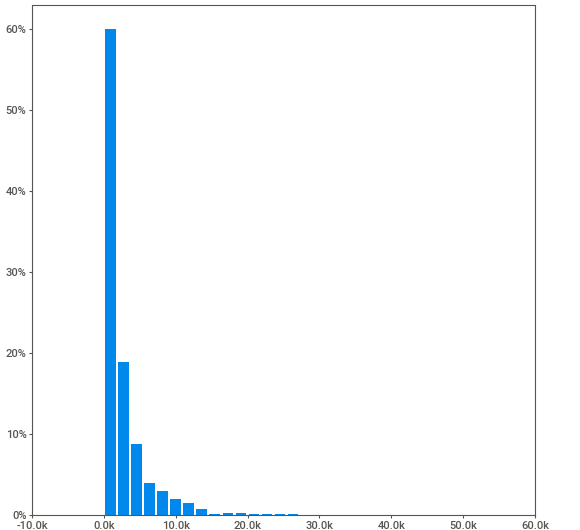
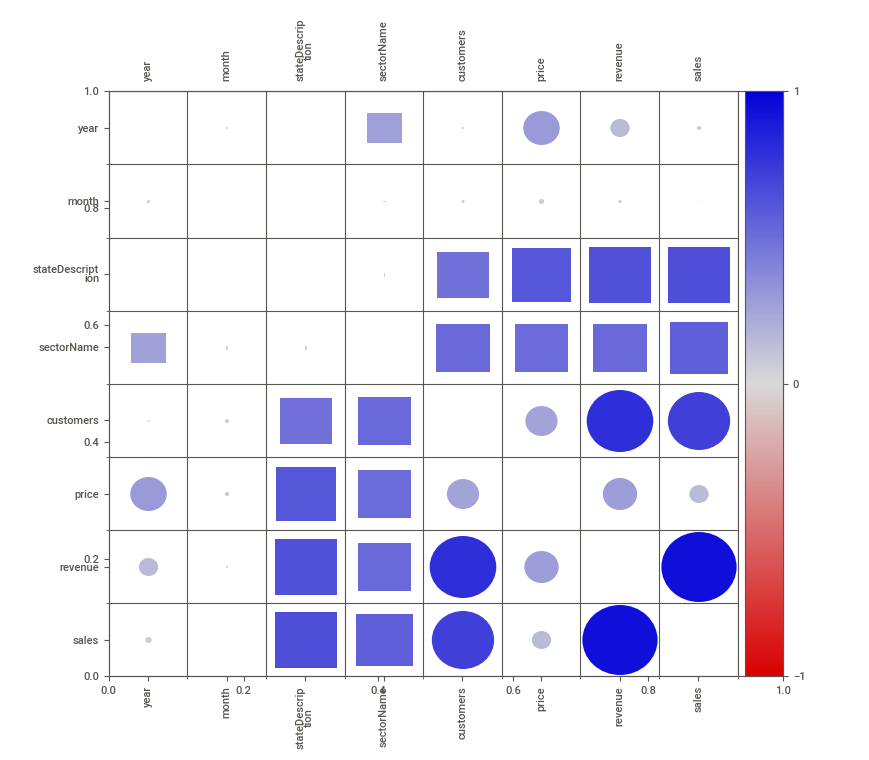
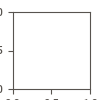

In [ ]:
#for no null values
noNull_df = sv.analyze(df_states)
noNull_df.show_notebook()

We can see that the data is distributed pretty well between the sectors (other than other). We are also able to see that modifying the null values did not change the zero values. There are still a lot of data with 0s in columns [customer, revenue, sales, price].

Now, we will generate these sweetviz analysis for each individual state

###**KLIB**

In [ ]:
!pip install --upgrade klib
import klib as klib

Next we can try using some of what klib has to visualize the distribution and correlation matrix

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

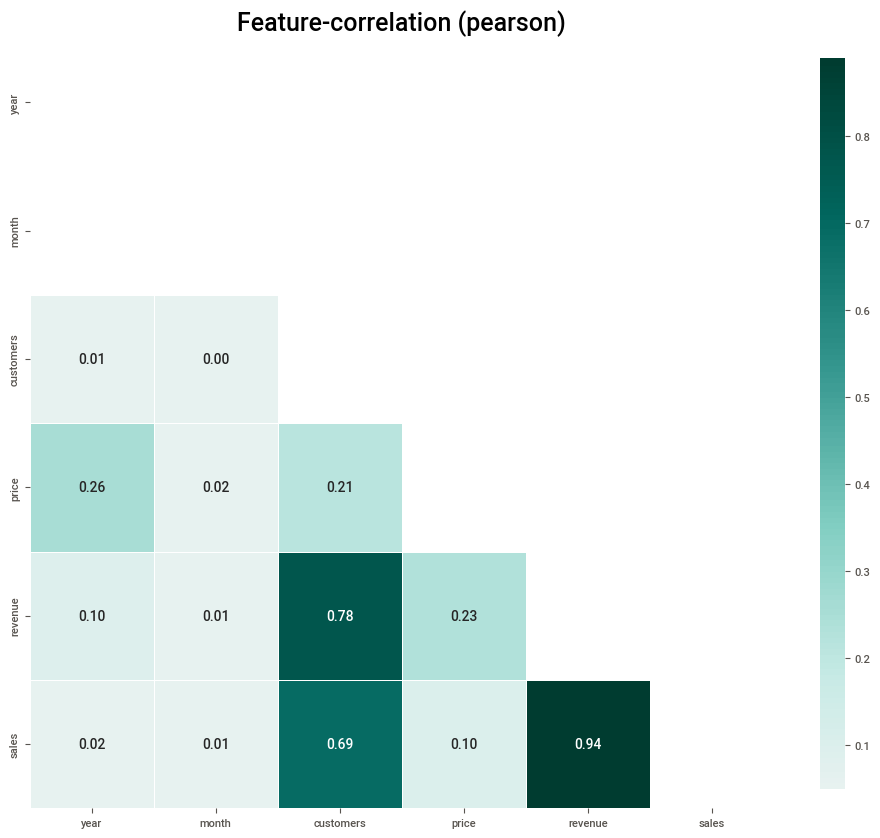

In [ ]:
#positive correlations
klib.corr_plot(df_states, split='pos')

Based on the plot above, the highest correlation is between:
- revenue x sales
  - sales directly contributes to revenue since you need to generate sales to generate revenue
- revenue x customers
  - the more customers you have the more revenue, direct correlation
- customers x sales
  - more customers contribute to the sales

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='sales', ylabel='Density'>

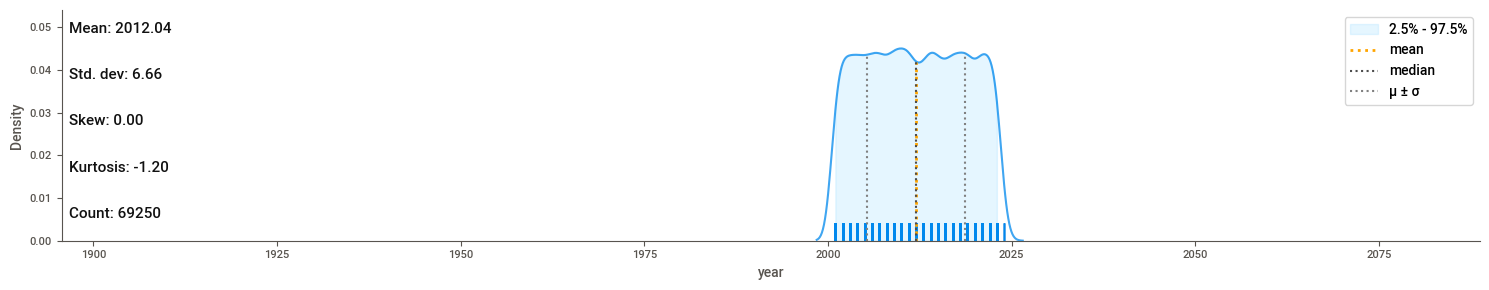

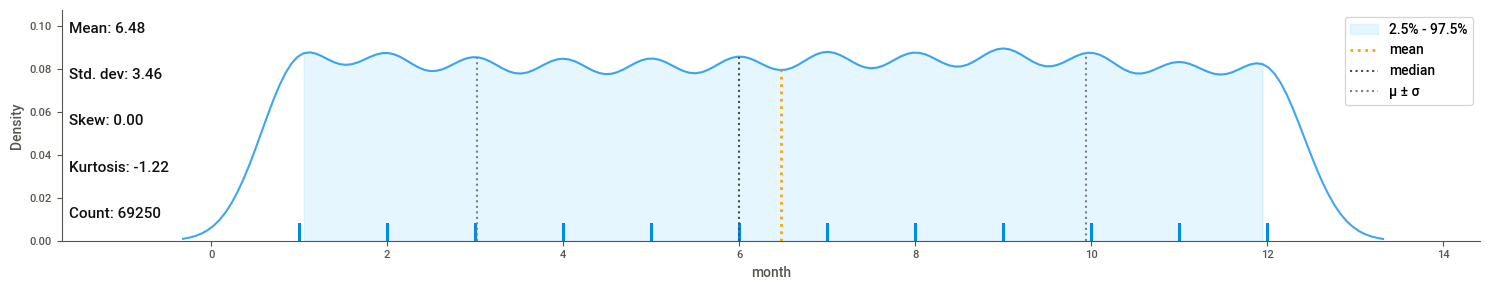

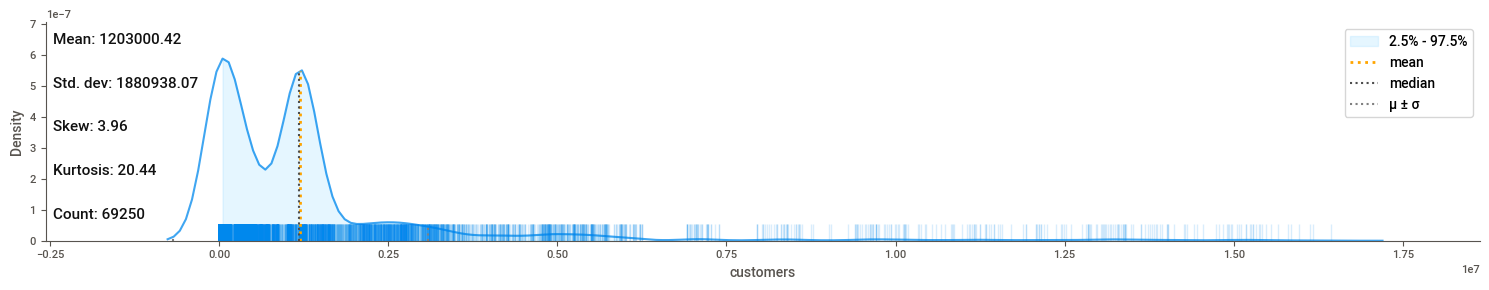

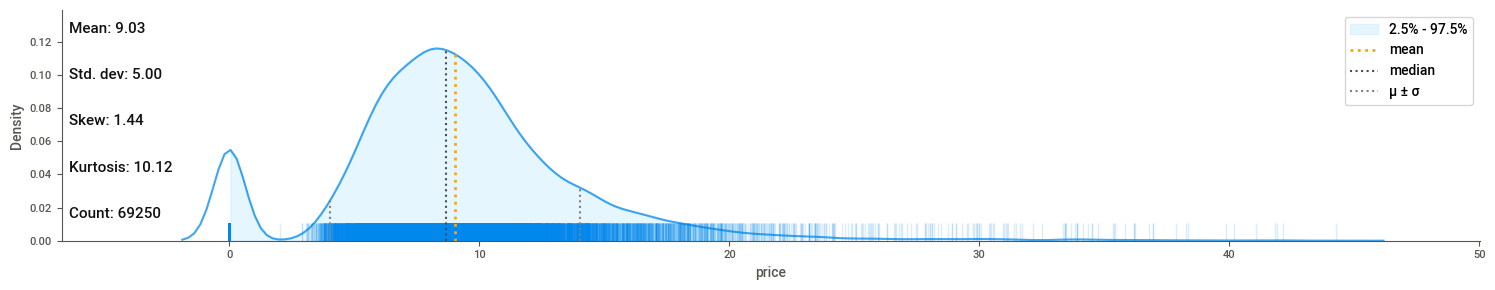

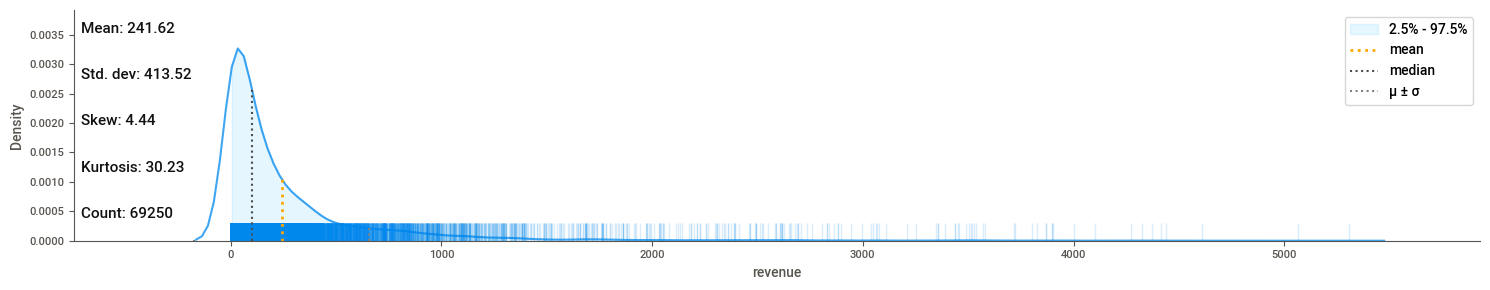

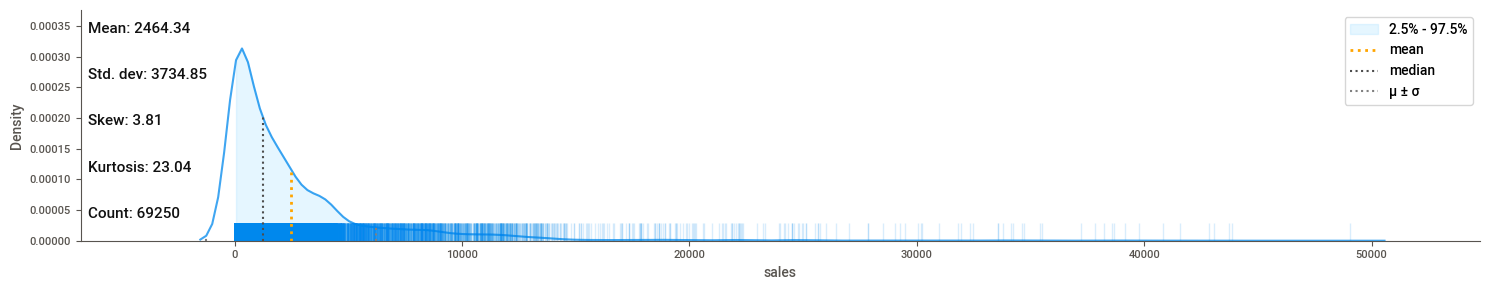

In [ ]:
#distribution of df
klib.dist_plot(df_states)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='sales', ylabel='Density'>

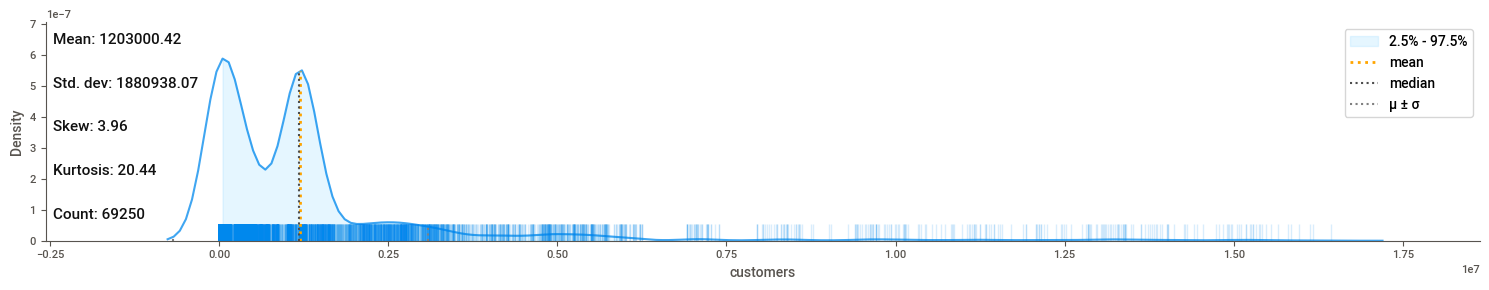

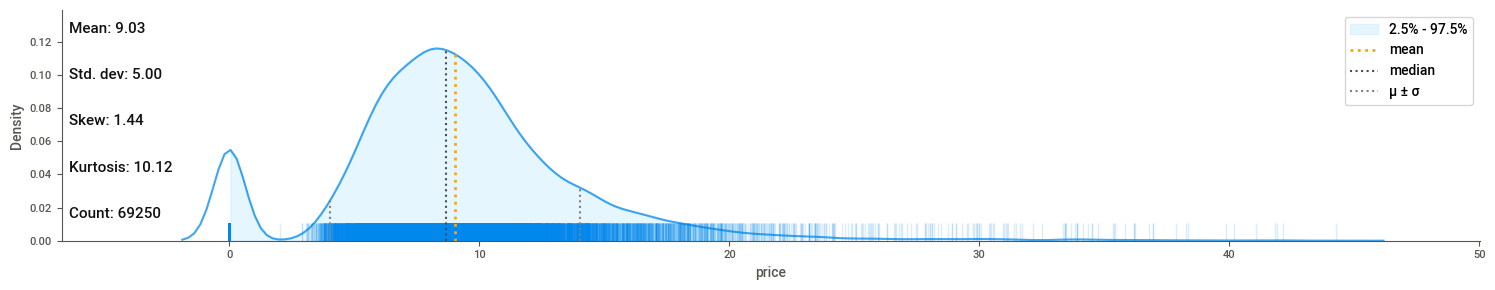

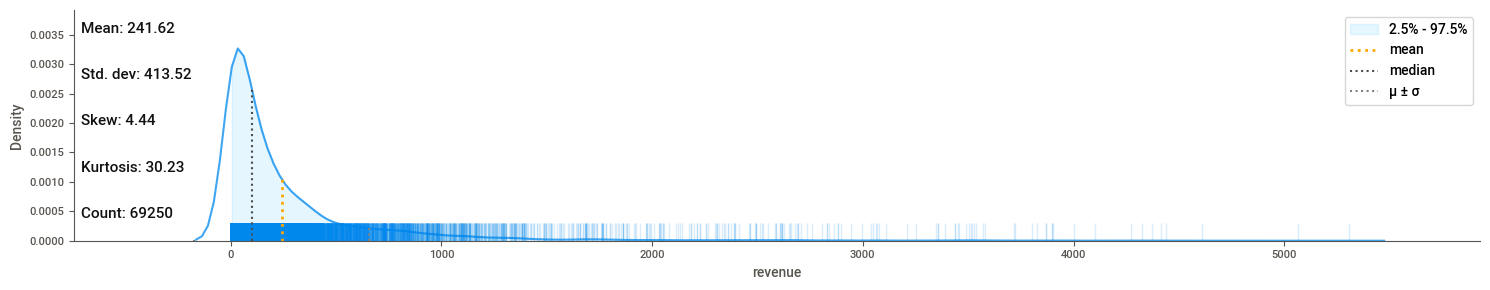

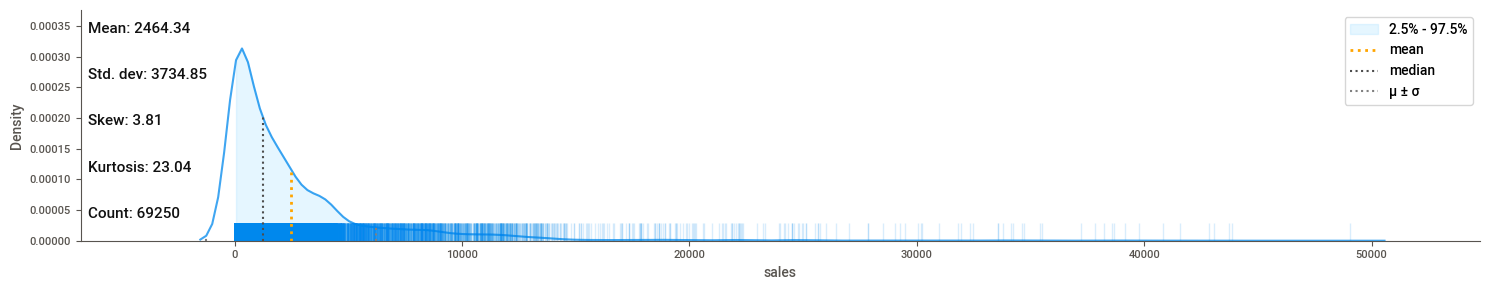

In [ ]:
#distribution of df_states
klib.dist_plot(df_states.drop(columns = ['year','month'], axis=1))

KLib has an auto-processing that drops duplicates and adjust the types as well as another function that adjusts the datatypes of the columns. We will see how this looks with our own cleaned up dataframe.

In [ ]:
df_klib = klib.data_cleaning(df_states)
df_klib = klib.convert_datatypes(df_klib)

Shape of cleaned data: (69250, 8) - Remaining NAs: 0


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 4.85 MB (-71.64%)



                                             |          | [  0%]   00:00 -> (? left)

KeyboardInterrupt: 

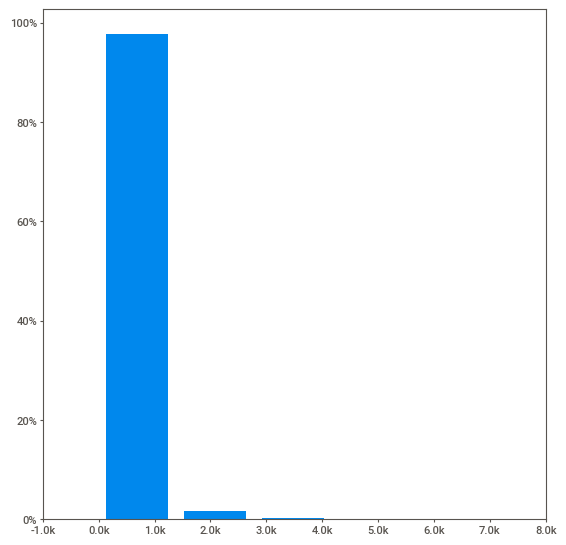

In [ ]:
#after cleaned df from klib
klib_df = sv.analyze(df_klib)
klib_df.show_notebook()

Didn't really do much. Though these tools are great for us to visualize our data and the correlations, they aren't very intuitive when it comes to cleaning data for us.

### **dabl**


In [ ]:
!pip install dabl
import dabl as db

In [ ]:
db.plot(df_states, 'price')



*   Frequency of price = $0 is high
*   Year and month are not continuous -- have to plot as a categorical (notice if it is sinusoidal-- seasonal -- time series) -- Jittering is the act of adding random noise to data in order to prevent overplotting in statistical graphs.
* Frequency for prices follow a bell curve -- excluding the price = 0



## Section IV: Finding Invalid 0 Values

List of Combinations with Invalid 0 Values:


*   customers = 0, revenue != 0
*   price = 0, sales != 0
*   sales = 0, revenue != 0
*   price = 0, revenue != 0



In [ ]:
# Find rows where customers = 0, revenue != 0
rows_with_zero_customers_non_zero_revenue = df_states[(df_states['customers'] == 0) & (df_states['revenue'] != 0)]

if not rows_with_zero_customers_non_zero_revenue.empty:
  print("There are rows with 0 customers but non-zero revenue.")
  print(rows_with_zero_customers_non_zero_revenue)
else:
  print("There are no rows with 0 customers but non-zero revenue.")

There are rows with 0 customers but non-zero revenue.
       year  month stateDescription      sectorName  customers  price  \
26290  2008      1   North Carolina  transportation        0.0   7.96   
26615  2008      2   North Carolina  transportation        0.0   7.67   
26799  2008      3   North Carolina  transportation        0.0   9.40   
39843  2011      9             Utah  transportation        0.0   9.95   
40105  2011     10             Utah  transportation        0.0   9.97   
40570  2011     11             Utah  transportation        0.0   8.63   
40626  2011     12             Utah  transportation        0.0   8.64   
42228  2012      5   North Carolina  transportation        0.0   8.03   
42525  2012      6   North Carolina  transportation        0.0   8.14   
42804  2012      7   North Carolina  transportation        0.0   8.00   
43251  2012      8   North Carolina  transportation        0.0   7.89   
43537  2012      9   North Carolina  transportation        0.0   7.87 

In [ ]:
# Find rows where price = 0 and sales != 0
rows_with_zero_price_non_zero_sales = df_states[(df_states['price'] == 0) & (df_states['sales'] != 0)]

if not rows_with_zero_price_non_zero_sales.empty:
  print("There are rows with price = 0 and sales != 0:")
  print(rows_with_zero_price_non_zero_sales)
else:
  print("There are no rows with price = 0 and sales != 0.")

There are rows with price = 0 and sales != 0:
       year  month stateDescription      sectorName     customers  price  \
15168  2005      1   North Carolina  transportation  1.203000e+06    0.0   
15374  2005      2   North Carolina  transportation  1.203000e+06    0.0   
15658  2005      3   North Carolina  transportation  1.203000e+06    0.0   
15902  2005      4   North Carolina  transportation  1.203000e+06    0.0   
16229  2005      5   North Carolina  transportation  1.203000e+06    0.0   
16621  2005      6   North Carolina  transportation  1.203000e+06    0.0   
17027  2005      7   North Carolina  transportation  1.203000e+06    0.0   
17154  2005      8   North Carolina  transportation  1.203000e+06    0.0   
17547  2005      9   North Carolina  transportation  1.203000e+06    0.0   
41064  2012      1     Rhode Island  transportation  1.000000e+00    0.0   
41367  2012      2     Rhode Island  transportation  1.000000e+00    0.0   
41606  2012      3     Rhode Island  trans

In [ ]:
# Find rows where sales = 0 and revenue != 0
rows_with_zero_sales_non_zero_revenue = df_states[(df_states['sales'] == 0) & (df_states['revenue'] != 0)]

if not rows_with_zero_sales_non_zero_revenue.empty:
  print("\nThere are rows with with sales = 0 and revenue != 0:")
  print(rows_with_zero_sales_non_zero_revenue)
else:
  print("\nThere are no rows with with sales = 0 and revenue != 0.")


There are no rows with with sales = 0 and revenue != 0.


In [ ]:
# Find rows with price = 0 and revenue !=0

rows_with_zero_price_non_zero_revenue = df_states[(df_states['price'] == 0) & (df_states['revenue'] != 0)]

if not rows_with_zero_price_non_zero_revenue.empty:
  print("There are rows with price = 0 and revenue != 0:")
  print(rows_with_zero_price_non_zero_revenue)
else:
  print("There are no rows with price = 0 and revenue != 0.")

There are no rows with price = 0 and revenue != 0.


Observation: All the invalid 0 combination root from the transportation sector. During feature engineering phase, we plan on dropping the transportation sector

##Section V: Distribution

In this section, we explore the distribution of data across states.

In [ ]:
state_describe = df_states.groupby('stateDescription').apply(lambda x: x.describe())
print(state_describe)

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='customers', data=df_states)

plt.title('Customer Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='price', data=df_states)

plt.title('Price Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='revenue', data=df_states)

plt.title('Revenue Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(30, 15))
sns.barplot(x='stateDescription', y='sales', data=df_states)

plt.title('Sales Distribution Across States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

A state from each category:

* New England: Vermont

* Middle Atlantic: New York

* Pacific Contiguous: California

* Pacific Noncontiguous: Hawaii

* District of Columbia: Washington, D.C.

* East North Central: Illinois

* West North Central: Minnesota

* South Atlantic: Florida

* East South Central: Alabama

* West South Central: Texas

* Mountain: Colorado

In [ ]:
states = {
    'New England': 'Vermont',
    'Middle Atlantic': 'New York',
    'Pacific Contiguous': 'California',
    'Pacific Noncontiguous': 'Hawaii',
    'East North Central': 'Illinois',
    'West North Central': 'Minnesota',
    'South Atlantic': 'Florida',
    'East South Central': 'Alabama',
    'West South Central': 'Texas',
    'Mountain': 'Colorado'
}

avg_prices = {}

for region, state in states.items():
    state_data = df[df['stateDescription'] == state]
    avg_prices[state] = state_data.groupby('year')['price'].mean()

plt.figure(figsize=(12, 8))
for state, avg_price in avg_prices.items():
    plt.plot(avg_price.index, avg_price.values, label=state)

plt.xlabel('Year')
plt.ylabel('Average Price (cents/kWh)')
plt.title('Average Electricity Prices by State')
plt.legend()
plt.grid(True)
plt.show()


# **Part 3: Feature Engineering**

## Section I: Adding 'season'

Since weather and overall temperature can affect energy prices, we are going to add a new feature to our dataset called 'Season' which indicates if what season an example is set in.

The season is indicated with a number from 0-3 where **0 = Winter**, **1 = Spring**, **2 = Summer**, and **3 = Fall**

In [ ]:
season_mappings = {
    12 : 0,
    1 : 0,
    2 : 0,
    3 : 1,
    4 : 1,
    5 : 1,
    6 : 2,
    7 : 2,
    8 : 2,
    9 : 3,
    10 : 3,
    11 : 3,
}

season_column = []

for index, row in df_states.iterrows():
  season_column.append(season_mappings[row['month']])

df_states.insert(2, "Season", season_column)
df_states = df_states.drop('month', axis=1)
df_states

year  Season stateDescription      sectorName     customers  price  \
0      2001       0          Wyoming     all sectors  1.203000e+06   4.31   
1      2001       0          Wyoming      commercial  1.203000e+06   5.13   
2      2001       0          Wyoming      industrial  1.203000e+06   3.26   
3      2001       0          Wyoming           other  1.203000e+06   4.75   
4      2001       0          Wyoming     residential  1.203000e+06   6.01   
...     ...     ...              ...             ...           ...    ...   
85865  2024       0         Arkansas     all sectors  1.717720e+06   9.63   
85866  2024       0         Arkansas      commercial  2.086690e+05  10.26   
85867  2024       0         Arkansas      industrial  3.495100e+04   7.08   
85868  2024       0         Arkansas     residential  1.474098e+06  11.24   
85869  2024       0         Arkansas  transportation  2.000000e+00  12.70   

         revenue       sales  
0       48.12840  1116.17208  
1       12.67978   247.08691  
2       19.60858   602.30484  
3        0.76868    16.17442  
4       15.07136   250.60591  
...          ...         ...  
85865  442.98773  4598.63147  
85866   97.79467   953.02154  
85867  109.92656  1553.02838  
85868  235.26399  2092.56172  
85869    0.00252     0.01984  

[69250 rows x 8 columns]

## Section II: One-Hot Encoding

In [ ]:
df_states = pd.get_dummies(df_states, columns = ['sectorName'], dtype = int)
df_states = pd.get_dummies(df_states, columns = ['stateDescription'], dtype = int)

##Section II: Standardizing and Normalizing

Since price is in cents per kWh, revenue is in millions of dollars, and sales is in million kWh, we first standardized these values to dollars. Additionally, because some of out features have numbers in the thousands while other features have numbers in the hundreds, we will be normalizing these values. That way, our model will not mistake the large quantity of customers as having more weight or the revenue to have less.

In [ ]:
# Converting cents to dollars
df_states['price'] = df_states['price'] / 100

# Converting millions of dollars to dollars
df_states['sales'] = df_states['sales'] * 1000000

# Converting millions of kWh to dollars
df_states['revenue'] = df_states['revenue'] * 1000000 * df_states['price']

# scaler = MinMaxScaler()

# df_states[['price', 'customers', 'sales', 'revenue']] = scaler.fit_transform(df_states[['price', 'customers', 'sales', 'revenue']])
# df_states

# **Part 2: Feature Selection**

## Section I: Calculate Mutual Information Between Features And Price


In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = df_states.drop('price', axis=1)
y = df_states['price']

mutual_info = mutual_info_regression(X, y)

mutual_info_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mutual_info})

mutual_info_df = mutual_info_df.sort_values('mutual_info', ascending=False)

mutual_info_df

feature  mutual_info
2                      customers     0.705687
3                        revenue     0.526352
4                          sales     0.406023
10     sectorName_transportation     0.166711
0                           year     0.141683
..                           ...          ...
11      stateDescription_Alabama     0.001930
52    stateDescription_Tennessee     0.001902
34  stateDescription_Mississippi     0.001815
33    stateDescription_Minnesota     0.001147
14     stateDescription_Arkansas     0.000000

[61 rows x 2 columns]

Customers, sales, and revenue all has incredibly high correlation. However, these features will not be available when predicting future data.

It is also strange that the transportation sector has a high correlation when none of the other sectors come close.

## Section II: Removing Unnecessary Information

In [ ]:
num_of_transportation_zero = len(df_states.loc[df_states['sectorName_transportation'] == 1].loc[df_states['price'] == 0])
num_of_transportation_invalid = len(df_states.loc[df_states['sectorName_transportation'] == 1].loc[df_states['price'] == 0].loc[df_states['customers'] != 0])
num_of_transportation = len(df_states.loc[df_states['sectorName_transportation'] == 1])

print('Percentage of transportation values with price = 0: ', num_of_transportation_zero/num_of_transportation)
print('Percentage of invalid transportation values: ', num_of_transportation_invalid/num_of_transportation)
print('Percentage of transportation in the whole dataset: ', num_of_transportation/len(df_states))

Percentage of transportation values with price = 0:  0.4607905138339921
Percentage of invalid transportation values:  0.12213438735177866
Percentage of transportation in the whole dataset:  0.18267148014440432


12% of the transportation examples is invalid (customers is nonzero, but price is zero). Since, 'transportation' is only 20% of the dataset, we are removing it.

Likewise, we are removing other because it could have contributed to double counting (the meaning was undefined).

In [ ]:
df_states = df_states.loc[df_states['sectorName_transportation'] == 0].loc[df_states['sectorName_other'] == 0] # Removing 'transportation' and 'other' sectors
df_states = df_states.drop(columns = ['sectorName_transportation', 'sectorName_other'])

Revenue, sales, customers are also removed due to feature leakage. Feature Leakage is when you use information in the model training process that would not be available at prediction time.

In [ ]:
df_states = df_states.drop(columns = ['revenue', 'sales', 'customers'])

## Section III: Splitting The Data

Currently, the data is not following proper time-series format as the dataset is spread across different times in different locations.

To remedy this, we are splitting the full dataset 'df_states' into 200 smaller datasets (50 states times 4 sectors) where each one contains the information (in chronological order) for one state in one sector.

First, we need to reverse the one-hot encoding.

In [ ]:
encoded_columns = [col for col in df_states.columns if col.startswith('sectorName_')]
df_states['sectorName'] = df_states[encoded_columns].idxmax(axis=1).str.replace('sectorName_', '')
df_states = df_states.drop(columns = encoded_columns)

df_states

year  Season   price  stateDescription_Alabama  \
0      2001       0  0.0431                         0   
1      2001       0  0.0513                         0   
2      2001       0  0.0326                         0   
4      2001       0  0.0601                         0   
7      2001       0  0.0736                         0   
...     ...     ...     ...                       ...   
85863  2024       0  0.1411                         0   
85865  2024       0  0.0963                         0   
85866  2024       0  0.1026                         0   
85867  2024       0  0.0708                         0   
85868  2024       0  0.1124                         0   

       stateDescription_Alaska  stateDescription_Arizona  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
4                            0                         0   
7                            0                         0   
...                        ...                       ...   
85863                        0                         1   
85865                        0                         0   
85866                        0                         0   
85867                        0                         0   
85868                        0                         0   

       stateDescription_Arkansas  stateDescription_California  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
4                              0                            0   
7                              0                            0   
...                          ...                          ...   
85863                          0                            0   
85865                          1                            0   
85866                          1                            0   
85867                          1                            0   
85868                          1                            0   

       stateDescription_Colorado  stateDescription_Connecticut  ...  \
0                              0                             0  ...   
1                              0                             0  ...   
2                              0                             0  ...   
4                              0                             0  ...   
7                              0                             0  ...   
...                          ...                           ...  ...   
85863                          0                             0  ...   
85865                          0                             0  ...   
85866                          0                             0  ...   
85867                          0                             0  ...   
85868                          0                             0  ...   

       stateDescription_Tennessee  stateDescription_Texas  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
4                               0                       0   
7                               0                       0   
...                           ...                     ...   
85863                           0                       0   
85865                           0                       0   
85866                           0                       0   
85867                           0                       0   
85868                           0                       0   

       stateDescription_Utah  stateDescription_Vermont  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
4 

In [ ]:
encoded_columns = [col for col in df_states.columns if col.startswith('stateDescription_')]
df_states['stateDescription'] = df_states[encoded_columns].idxmax(axis=1).str.replace('stateDescription_', '')
df_states = df_states.drop(columns = encoded_columns)

df_states

year  Season   price   sectorName stateDescription
0      2001       0  0.0431  all sectors          Wyoming
1      2001       0  0.0513   commercial          Wyoming
2      2001       0  0.0326   industrial          Wyoming
4      2001       0  0.0601  residential          Wyoming
7      2001       0  0.0736  residential   South Carolina
...     ...     ...     ...          ...              ...
85863  2024       0  0.1411  residential          Arizona
85865  2024       0  0.0963  all sectors         Arkansas
85866  2024       0  0.1026   commercial         Arkansas
85867  2024       0  0.0708   industrial         Arkansas
85868  2024       0  0.1124  residential         Arkansas

[55400 rows x 5 columns]

In [ ]:
datasets = []

states =  df_states['stateDescription'].unique()
sectors = df_states['sectorName'].unique()

for state in states:
  for sector in sectors:

    dataset = df_states.loc[df_states['stateDescription'] == state].loc[df_states['sectorName'] == sector]
    dataset = dataset.sort_values(['year', 'Season'], ascending=[True, True])
    dataset['price'] = dataset.groupby(['year', 'Season'])['price'].transform('mean')
    dataset = dataset.drop_duplicates()
    dataset.set_index(['year', 'Season'])

    datasets.append(dataset)

datasets

[       year  Season     price   sectorName stateDescription
 0      2001       0  0.043833  all sectors          Wyoming
 748    2001       1  0.043333  all sectors          Wyoming
 1814   2001       2  0.045233  all sectors          Wyoming
 2730   2001       3  0.045933  all sectors          Wyoming
 3919   2002       0  0.046233  all sectors          Wyoming
 ...     ...     ...       ...          ...              ...
 81855  2023       0  0.081333  all sectors          Wyoming
 82727  2023       1  0.082833  all sectors          Wyoming
 83635  2023       2  0.084600  all sectors          Wyoming
 84600  2023       3  0.084900  all sectors          Wyoming
 85746  2024       0  0.083900  all sectors          Wyoming
 
 [93 rows x 5 columns],
        year  Season     price  sectorName stateDescription
 1      2001       0  0.051733  commercial          Wyoming
 749    2001       1  0.053433  commercial          Wyoming
 1815   2001       2  0.054800  commercial          Wyoming
 2

# **Part 4: Model Selection**

Here, we will test different models and analyze their performances to determine the best one to use.

## Section I: Model Understanding

In [ ]:
# Necessary Imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Testing if the model is stationary

adf_test = adfuller(df_states['price'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

if (adf_test[1] < 0.05):
    print("This dataset is likely to be STATIONARY.")
else:
    print("This dataset is likely to be NOT stationary.")

ADF Statistic: -13.419096
p-value: 0.000000
This dataset is likely to be STATIONARY.


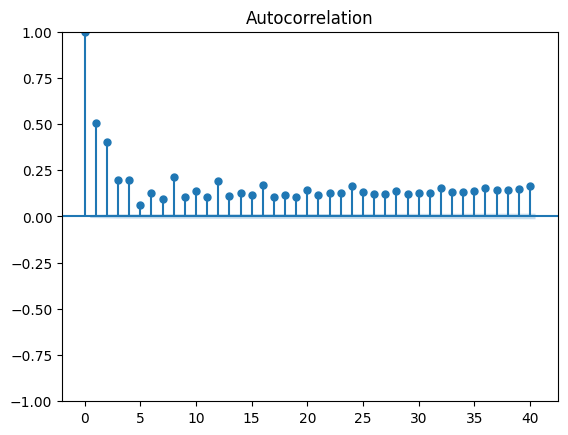

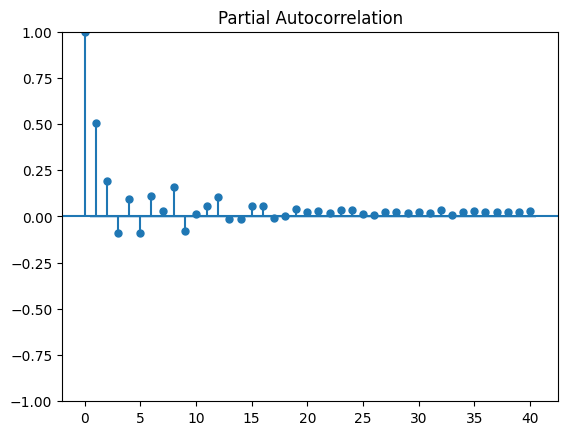

In [ ]:
# Testing which ARIMA parameters are best to use for this dataset
plot_acf(df_states['price'], lags=40)
plot_pacf(df_states['price'], lags=40)
plt.show()

These charts indicate that ARIMA(1,0,1) is a good model to use.

## Section II: ARIMA vs. SARIMA

Now, we will test to see which model works better: ARIMA and SARIMA

SARIMA works well with seasonality, so we can test if the datasets we have are seasonal. Ideally, there should be multiple waves or small bumps in the graph.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

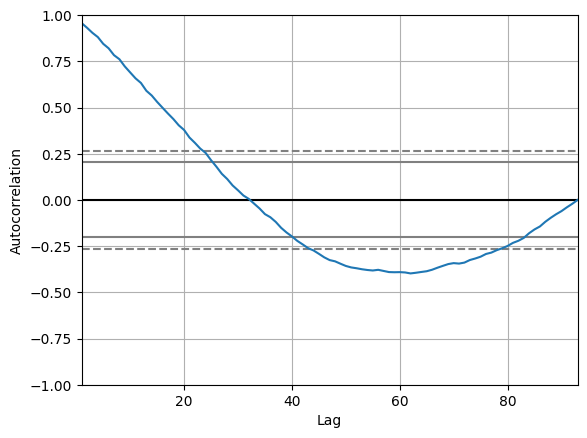

In [ ]:
autocorrelation_plot(datasets[5]['price'])

There are no small bumps in the plot which indicates that seasonality is low.

However, we can still try each model and see which produces a smaller error when it comes to predictions. We will train the model on each dataset from before 2020 and test its accuracy.

In [ ]:
average_err = 0

for dataset in datasets:
  train = dataset.loc[dataset['year'] < 2020]
  test = dataset.loc[dataset['year'] >= 2020]

  # Fit the ARIMA model on the training dataset
  model_train = ARIMA(train['price'], order=(1, 0, 1))
  model_train_fit = model_train.fit()

  # Forecast on the test dataset
  predictions = model_train_fit.predict(start = 1, end = len(test))

  # Calculate the mean squared error
  mse = mean_squared_error(test['price'], predictions)
  rmse = mse**0.5
  average_err = average_err + rmse

average_err = average_err / len(datasets)
print('Average RMSE: ', average_err)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Average RMSE:  0.11569762837460423


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The ARIMA model had an average error of 11.5%. Now, we can test the same for SARIMA.

In [ ]:
average_err = 0

for dataset in datasets:
  train = dataset.loc[dataset['year'] < 2020]
  test = dataset.loc[dataset['year'] >= 2020]

  # Fit the ARIMA model on the training dataset
  model_train = SARIMAX(train['price'], order=(1, 0, 1), seasonal_order=(1,0,1,4))
  model_train_fit = model_train.fit()

  # Forecast on the test dataset
  predictions = model_train_fit.predict(start = 1, end = len(test))

  # Calculate the mean squared error
  mse = mean_squared_error(test['price'], predictions)
  rmse = mse**0.5
  average_err = average_err + rmse

average_err = average_err / len(datasets)
print('Average RMSE: ', average_err)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Average RMSE:  0.11851007576235183


SARIMA has an average error of 11.8%. ARIMA had a lower error of 11.5%, so we'll use that.

## Section III: Getting Predictions from ARIMA

In [ ]:
datasets[0]

year  Season     price   sectorName stateDescription
0      2001       0  0.043833  all sectors          Wyoming
748    2001       1  0.043333  all sectors          Wyoming
1814   2001       2  0.045233  all sectors          Wyoming
2730   2001       3  0.045933  all sectors          Wyoming
3919   2002       0  0.046233  all sectors          Wyoming
...     ...     ...       ...          ...              ...
81855  2023       0  0.081333  all sectors          Wyoming
82727  2023       1  0.082833  all sectors          Wyoming
83635  2023       2  0.084600  all sectors          Wyoming
84600  2023       3  0.084900  all sectors          Wyoming
85746  2024       0  0.083900  all sectors          Wyoming

[93 rows x 5 columns]

Now, we can make predictions for the price in a state and a sector for each season until 2030.

In [ ]:
df_predictions = pd.DataFrame(columns = ['year', 'Season', 'price', 'stateDescription', 'sectorName'])
df_years = np.array(['2024', '2024', '2024', '2025', '2025', '2025', '2025', '2026', '2026', '2026', '2026', '2027', '2027', '2027', '2027', '2028', '2028', '2028', '2028', '2029', '2029', '2029', '2029', '2030', '2030', '2030', '2030'])
df_seasons = np.array([1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

for dataset in datasets:
  df_temp_predictions = pd.DataFrame(columns = ['year', 'Season', 'price', 'stateDescription', 'sectorName'])
  df_temp_predictions['year'] = df_years
  df_temp_predictions['Season'] = df_seasons
  df_temp_predictions['stateDescription'] = np.full(27, dataset['stateDescription'].unique()[0])
  df_temp_predictions['sectorName'] = np.full(27, dataset['sectorName'].unique()[0])

  model = ARIMA(dataset['price'], order=(1, 0, 1))
  model_fit = model.fit()

  # Forecast on the test dataset
  predictions = model_fit.predict(start = 0, end = 26)

  df_temp_predictions['price'] = np.array(predictions)
  df_predictions = pd.concat([df_predictions, df_temp_predictions], ignore_index=True)


df_predictions

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

year Season     price stateDescription   sectorName
0     2024      1  0.067762          Wyoming  all sectors
1     2024      2  0.044130          Wyoming  all sectors
2     2024      3  0.043636          Wyoming  all sectors
3     2025      0  0.045510          Wyoming  all sectors
4     2025      1  0.046202          Wyoming  all sectors
...    ...    ...       ...              ...          ...
5395  2029      3  0.102811     Pennsylvania  residential
5396  2030      0  0.108955     Pennsylvania  residential
5397  2030      1  0.104555     Pennsylvania  residential
5398  2030      2  0.103709     Pennsylvania  residential
5399  2030      3  0.107600     Pennsylvania  residential

[5400 rows x 5 columns]

Now that we have our predictions, we should revert the normalized prices to their original values.

In [ ]:
max_price = max(df['price'])
min_price = min(df['price'])

df_predictions_copy = df_predictions.copy()
df_predictions_copy['price'] = df_predictions_copy['price'] * (max_price - min_price) + min_price
df_predictions_copy

year Season      price stateDescription   sectorName
0     2024      1   7.905772          Wyoming  all sectors
1     2024      2   5.148590          Wyoming  all sectors
2     2024      3   5.091003          Wyoming  all sectors
3     2025      0   5.309619          Wyoming  all sectors
4     2025      1   5.390436          Wyoming  all sectors
...    ...    ...        ...              ...          ...
5395  2029      3  11.994937     Pennsylvania  residential
5396  2030      0  12.711754     Pennsylvania  residential
5397  2030      1  12.198396     Pennsylvania  residential
5398  2030      2  12.099787     Pennsylvania  residential
5399  2030      3  12.553641     Pennsylvania  residential

[5400 rows x 5 columns]

In [ ]:

for dataset in datasets:
  df_predictions_copy = pd.concat([df_predictions_copy, dataset])

df_predictions_copy = df_predictions_copy.sort_values(['year', 'Season'], ascending=[True, True])
df_predictions_copy

year Season      price stateDescription   sectorName
0     2001      0   0.043833          Wyoming  all sectors
1     2001      0   0.051733          Wyoming   commercial
2     2001      0   0.034033          Wyoming   industrial
4     2001      0   0.062700          Wyoming  residential
183   2001      0   0.057800   South Carolina  all sectors
...    ...    ...        ...              ...          ...
5291  2030      3  13.055893          Florida  residential
5318  2030      3  10.445613     Pennsylvania  all sectors
5345  2030      3  10.746648     Pennsylvania   commercial
5372  2030      3   8.100830     Pennsylvania   industrial
5399  2030      3  12.553641     Pennsylvania  residential

[24000 rows x 5 columns]

In [ ]:
df_predictions_copy.to_csv('/content/drive/MyDrive/final_tableau.csv', index=False)